# 1. Install & Import Dependencies

In [1]:
import os
import json
import random
from pathlib import Path
from typing import List, Tuple, Dict

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pickle

import pandas as pd

# Optional: optuna for HPO (install if needed)
try:
    import optuna
    OPTUNA_AVAILABLE = True
except Exception:
    OPTUNA_AVAILABLE = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f"Using device: {DEVICE}")

import shutil
from IPython.display import FileLink

Using device: cuda


# 2. Create Organized Output Structure

In [2]:
def create_output_structure():
    """Create organized output folder structure"""
    base_dirs = {
        'outputs': 'MAE_SSL_RHYTHM',
        'default_mae': 'MAE_SSL_RHYTHM/Default_MAE_SSL',
        'default_models': 'MAE_SSL_RHYTHM/Default_MAE_SSL/Model_Save',
        'default_history': 'MAE_SSL_RHYTHM/Default_MAE_SSL/Training_History',
        'default_matrix': 'MAE_SSL_RHYTHM/Default_MAE_SSL/Matrix',
        'hpo_mae': 'MAE_SSL_RHYTHM/HPO_MAE_SSL',
        'hpo_models': 'MAE_SSL_RHYTHM/HPO_MAE_SSL/Model_Save',
        'hpo_history': 'MAE_SSL_RHYTHM/HPO_MAE_SSL/Training_History',
        'hpo_matrix': 'MAE_SSL_RHYTHM/HPO_MAE_SSL/Matrix',
    }
    
    for dir_path in base_dirs.values():
        os.makedirs(dir_path, exist_ok=True)
    
    return base_dirs

def create_class_mapping_json(classes, save_path='MAE_SSL_RHYTHM/class_mapping.json'):
    """Create class mapping JSON file"""
    class_mapping = {
        'classes': classes,
        'class_to_idx': {cls: idx for idx, cls in enumerate(classes)},
        'idx_to_class': {idx: cls for idx, cls in enumerate(classes)},
        'description': {
            'N': 'Normal Rhythm',
            'VFL': 'Ventricular Flutter',
            'AFIB': 'Atrial Fibrillation'
        }
    }
    
    with open(save_path, 'w') as f:
        json.dump(class_mapping, f, indent=2)
    
    print(f"Class mapping saved to {save_path}")
    return class_mapping

def create_readme_file(save_path='MAE_SSL_RHYTHM/README.md'):
    """Create comprehensive README file"""
    readme_content = """# ECG Rhythm Classification with Masked Autoencoder + Self-Supervised Learning (MAE+SSL)

This project implements ECG rhythm classification using a Transformer-based Masked Autoencoder with Self-Supervised Learning approach for comprehensive evaluation and comparison between default configuration and hyperparameter-optimized models.

## Project Structure

```
MAE_SSL_RHYTHM/
├── README.md                           # This file
├── class_mapping.json                  # Class labels and descriptions
├── config_default.json                 # Default configuration parameters
├── config_hpo.json                     # Best hyperparameters from tuning
├── detailed_metrics_comparison.xlsx    # Comprehensive metrics comparison
│
├── Default_MAE_SSL/                    # Default MAE+SSL model results
│   ├── Model_Save/                     # Trained model files
│   │   ├── fold1.pth                   # Model weights for fold 1
│   │   ├── fold2.pth                   # Model weights for fold 2
│   │   ├── fold3.pth                   # Model weights for fold 3
│   │   ├── fold4.pth                   # Model weights for fold 4
│   │   └── fold5.pth                   # Model weights for fold 5
│   │
│   ├── Training_History/               # Training progress visualization
│   │   ├── training_history_per_fold.png  # Loss/accuracy plots for all folds
│   │   ├── fold1_history.png           # Individual fold training history
│   │   ├── fold2_history.png
│   │   ├── fold3_history.png
│   │   ├── fold4_history.png
│   │   └── fold5_history.png
│   │
│   └── Matrix/                         # Confusion matrices and evaluation
│       ├── aggregated_confusion_matrix.png     # Combined results
│       ├── train_confusion_matrix.png          # Training set evaluation
│       ├── test_confusion_matrix.png           # Test set evaluation
│       ├── fold1_train_confusion_matrix.png    # Per-fold training matrices
│       ├── fold1_val_confusion_matrix.png      # Per-fold validation matrices
│       ├── fold1_test_confusion_matrix.png     # Per-fold test matrices
│       └── ... (similar for folds 2-5)
│
└── HPO_MAE_SSL/                        # Hyperparameter-optimized MAE+SSL results
    ├── Model_Save/                     # Same structure as Default_MAE_SSL
    ├── Training_History/
    └── Matrix/
```

## Dataset Classes

The model classifies ECG rhythms into 3 categories:
- **N**: Normal Rhythm
- **VFL**: Ventricular Flutter
- **AFIB**: Atrial Fibrillation

## Model Architecture: MAE + Self-Supervised Learning

### Architecture Overview:
- **Base Model**: Transformer-based Masked Autoencoder with SSL
- **Input**: 1D ECG rhythm signals (variable length, padded to max length in batch)
- **Patch Size**: Configurable (default: 16)
- **Embedding Dimension**: Configurable (default: 128)
- **Attention Heads**: Configurable (default: 4)
- **Transformer Layers**: Configurable (default: 6)
- **Masking Ratio**: Configurable (default: 0.5)

### Self-Supervised Learning Components:
1. **Contrastive Loss**: Maximizes agreement between augmented views of the same sample
2. **Reconstruction Loss**: Standard MAE reconstruction of masked patches
3. **Combined Training**: Multi-task learning with weighted loss combination

### Training Strategy:
- **Two-Phase Training**:
  - Phase 1: Self-supervised pretraining with contrastive + reconstruction loss
  - Phase 2: Fine-tuning with classification loss
- **Data Augmentation**: Time-shifting, amplitude scaling, noise injection for contrastive learning

## Training Strategy

### 5-Fold Cross Validation
- Stratified splitting to maintain class balance
- Each fold trained for specified epochs
- Best fold selected based on validation accuracy

### Two Training Approaches:
1. **Default Configuration**: Pre-defined hyperparameters
2. **Hyperparameter Optimization**: Optuna-based tuning with 3-fold inner CV

### Optimization Details
- **Optimizer**: AdamW
- **Loss Functions**: 
  - Contrastive Loss (Self-Supervised)
  - Reconstruction Loss (MAE)
  - CrossEntropyLoss (Classification)
- **Learning Rate**: Tunable (default: 1e-3)
- **Weight Decay**: Tunable (default: 1e-4)
- **Batch Size**: Configurable (default: 64)
- **SSL Weight**: Balance between SSL and supervised loss (default: 0.5)

## Evaluation Metrics

### Per-Class Metrics:
- **Accuracy**: (TP + TN) / (TP + TN + FP + FN) per class
- **Sensitivity (Recall)**: TP / (TP + FN) per class
- **Specificity**: TN / (TN + FP) per class  
- **F1-Score**: 2 * (Precision * Recall) / (Precision + Recall) per class

### Aggregated Metrics:
- **Overall Accuracy**: Mean of per-class accuracies
- **Macro Average**: Unweighted mean of per-class metrics
- **Weighted Average**: Sample-weighted mean of per-class metrics

## Files Description

### Configuration Files
- `config_default.json`: Default hyperparameters and settings
- `config_hpo.json`: Best hyperparameters found through optimization
- `class_mapping.json`: Class labels and descriptions

### Model Files
- `Default_MAE_SSL/Model_Save/fold*.pth`: Trained model weights for each fold
- `HPO_MAE_SSL/Model_Save/fold*.pth`: Optimized model weights for each fold

### Results Files
- `detailed_metrics_comparison.xlsx`: Comprehensive metrics comparison with sheets:
  - Default_Train_MAE_SSL: Training metrics for all folds (Default)
  - Tuning_Train_MAE_SSL: Training metrics for all folds (HPO)
  - Default_Test_MAE_SSL: Test metrics for best Default fold
  - Tuning_Test_MAE_SSL: Test metrics for best HPO fold

### Visualization Files
- Training history plots showing loss and accuracy progression
- Confusion matrices for train, validation, and test sets
- Per-fold and aggregated evaluation visualizations

## Usage

1. **Load Best Model**:
   ```python
   # Load best fold from either Default or HPO
   model_path = "MAE_SSL_RHYTHM/Default_MAE_SSL/Model_Save/fold{best_fold}.pth" 
   model.load_state_dict(torch.load(model_path))
   ```

2. **View Configuration**:
   ```python
   with open('MAE_SSL_RHYTHM/config_default.json', 'r') as f:
       config = json.load(f)
   ```

3. **Load Class Mapping**:
   ```python
   with open('MAE_SSL_RHYTHM/class_mapping.json', 'r') as f:
       class_info = json.load(f)
   ```

## Performance Summary

The project compares Default MAE+SSL vs Hyperparameter-Optimized MAE+SSL across:
- **Training Performance**: 5-fold cross-validation results
- **Generalization**: Test set evaluation on best fold
- **Robustness**: Per-class performance analysis
- **Efficiency**: Training convergence and stability
- **SSL Benefits**: Improved feature learning through self-supervision

Best models are selected based on validation accuracy and evaluated on held-out test set for final performance assessment.

## Dependencies

- PyTorch
- scikit-learn  
- NumPy
- Pandas
- Matplotlib
- Seaborn
- Optuna (optional, for hyperparameter optimization)

## Notes

- All models use the same random seed for reproducibility
- Stratified splitting ensures balanced class representation
- Per-rhythm normalization applied (z-score normalization)
- Variable-length sequences handled via padding in batch collation
- Self-supervised learning enhances representation quality
"""
    
    with open(save_path, 'w') as f:
        f.write(readme_content)
    
    print(f"README.md created at {save_path}")

# Create output structure
OUTPUT_DIRS = create_output_structure()
print("Created organized output directory structure")

Created organized output directory structure


# 3. Load Datasets

In [3]:
for root, dirs, files in os.walk('/kaggle/input'):
    print(root)

/kaggle/input
/kaggle/input/split-rythm
/kaggle/input/split-rythm/SPLIT_SLIDING_FINAL
/kaggle/input/split-rythm/SPLIT_SLIDING_FINAL/test
/kaggle/input/split-rythm/SPLIT_SLIDING_FINAL/test/N
/kaggle/input/split-rythm/SPLIT_SLIDING_FINAL/test/VFL
/kaggle/input/split-rythm/SPLIT_SLIDING_FINAL/test/AFIB
/kaggle/input/split-rythm/SPLIT_SLIDING_FINAL/train
/kaggle/input/split-rythm/SPLIT_SLIDING_FINAL/train/N
/kaggle/input/split-rythm/SPLIT_SLIDING_FINAL/train/VFL
/kaggle/input/split-rythm/SPLIT_SLIDING_FINAL/train/AFIB


=== Dataset Distribution (Train) ===
AFIB      : 1600
N         : 1600
VFL       : 1600

=== Dataset Distribution (Test) ===
AFIB      : 400
N         : 400
VFL       : 400


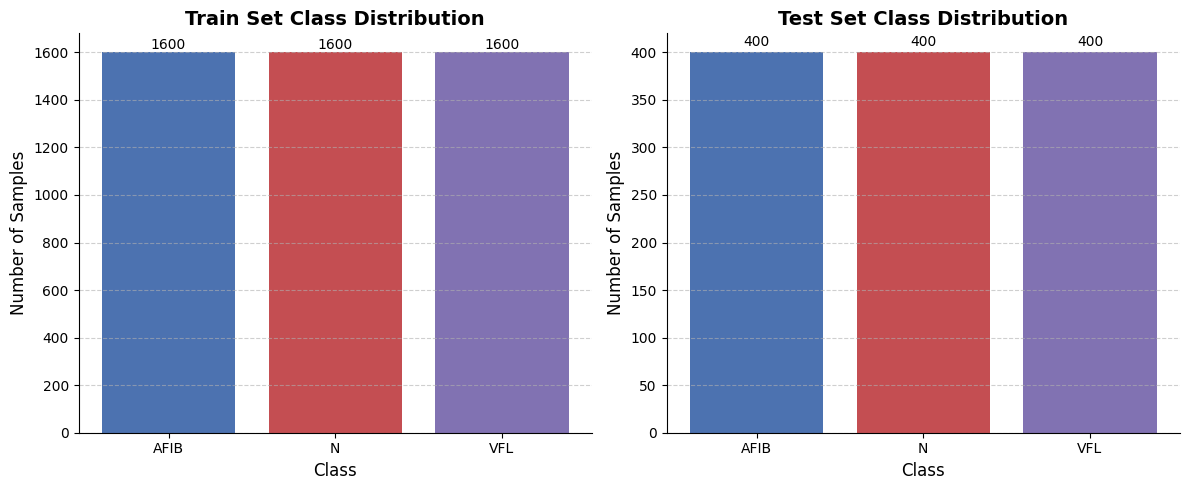

In [4]:
# ✅ UPDATED: Dataset paths for rhythm classification
base_dir = '/kaggle/input/split-rythm/SPLIT_SLIDING_FINAL'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

def count_files_per_class(directory):
    """Count the number of files per class in a given directory."""
    counts = {}
    for class_name in sorted(os.listdir(directory)):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            counts[class_name] = len(os.listdir(class_path))
    return counts

# Count data per class
train_counts = count_files_per_class(train_dir)
test_counts = count_files_per_class(test_dir)

# Display in console
print("=== Dataset Distribution (Train) ===")
for k, v in train_counts.items():
    print(f"{k:<10}: {v}")

print("\n=== Dataset Distribution (Test) ===")
for k, v in test_counts.items():
    print(f"{k:<10}: {v}")

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
bar_colors = ['#4C72B0', '#C44E52', '#8172B2']  # 3 colors for 3 classes

# Plot Train
axes[0].bar(train_counts.keys(), train_counts.values(), color=bar_colors)
axes[0].set_title('Train Set Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class', fontsize=12)
axes[0].set_ylabel('Number of Samples', fontsize=12)

# Add numbers on bars (Train)
for i, value in enumerate(train_counts.values()):
    axes[0].text(i, value + 3, str(value), ha='center', va='bottom', fontsize=10)

# Plot Test
axes[1].bar(test_counts.keys(), test_counts.values(), color=bar_colors)
axes[1].set_title('Test Set Class Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Class', fontsize=12)
axes[1].set_ylabel('Number of Samples', fontsize=12)

# Add numbers on bars (Test)
for i, value in enumerate(test_counts.values()):
    axes[1].text(i, value + 3, str(value), ha='center', va='bottom', fontsize=10)

# General styling
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [5]:
class ECGRhythmDataset(Dataset):
    """Load .npy rhythm files and labels. Assumes folder structure where parent folder name is class label."""
    def __init__(self, root_dirs: List[Path], classes: List[str], transform=None):
        self.files = []
        self.labels = []
        self.classes = classes
        self.class_to_idx = {c: i for i, c in enumerate(classes)}
        for root in root_dirs:
            root = Path(root)
            if not root.exists():
                continue
            for p in root.glob('**/*.npy'):
                # guess class from parent directory name
                try:
                    cls = p.parent.name
                    if cls not in self.class_to_idx:
                        # fallback: try to extract from filename
                        fname = p.name
                        # Check if any class name is in filename
                        found = False
                        for class_name in self.class_to_idx.keys():
                            if class_name in fname:
                                cls = class_name
                                found = True
                                break
                        if not found:
                            continue
                    self.files.append(str(p))
                    self.labels.append(self.class_to_idx[cls])
                except Exception:
                    continue
        assert len(self.files) == len(self.labels), "files/labels mismatch"
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        arr = np.load(self.files[idx])
        # ensure 1D
        arr = np.asarray(arr, dtype=np.float32).squeeze()
        # normalize per rhythm segment
        if arr.std() > 0:
            arr = (arr - arr.mean()) / (arr.std() + 1e-8)
        label = int(self.labels[idx])
        # convert to torch tensor
        x = torch.from_numpy(arr).float()
        return x, label


# 4. Config

In [6]:
# ✅ UPDATED: Configuration for rhythm classification (3 classes)
DEFAULT_CONFIG = {
    "seed": 42,
    "dataset": {
        "train_dirs": ["/kaggle/input/split-rythm/SPLIT_SLIDING_FINAL/train"],
        "test_dirs": ["/kaggle/input/split-rythm/SPLIT_SLIDING_FINAL/test"],
        "classes": ["AFIB", "N", "VFL"],  # 3 classes for rhythm
    },
    "training": {
        "device": "cuda" if torch.cuda.is_available() else "cpu",
        "batch_size": 64,
        "num_epochs": 20,
        "learning_rate": 1e-3,
        "weight_decay": 1e-4,
        "num_workers": 2,
        "ssl_weight": 0.5,
        "pretrain_epochs": 20,
    },
    "model": {
        "patch_size": 16,
        "dim": 128,
        "n_heads": 4,
        "n_layers": 6,
        "mask_ratio": 0.5,
        "dropout": 0.1,
        "projection_dim": 64,
        "temperature": 0.07,
    },
}

os.makedirs('MAE_SSL_RHYTHM', exist_ok=True)
with open('MAE_SSL_RHYTHM/config_default.json', 'w') as f:
    json.dump(DEFAULT_CONFIG, f, indent=2)

# Create class mapping and README
create_class_mapping_json(DEFAULT_CONFIG['dataset']['classes'])
create_readme_file()

# Utilities
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(DEFAULT_CONFIG['seed'])


def collate_ecg(batch):
    """Pad to max length in batch to enable batching if rhythms vary in length."""
    xs, ys = zip(*batch)
    lengths = [x.shape[0] for x in xs]
    maxlen = max(lengths)
    batch_x = torch.zeros(len(xs), maxlen)
    for i, x in enumerate(xs):
        batch_x[i, :x.shape[0]] = x
    return batch_x.unsqueeze(1), torch.tensor(ys, dtype=torch.long)

Class mapping saved to MAE_SSL_RHYTHM/class_mapping.json
README.md created at MAE_SSL_RHYTHM/README.md


# 5. Load Pre-Train Model Transformer MAE+SSL

In [7]:
class PatchEmbed1D(nn.Module):
    def __init__(self, in_chans=1, patch_size=16, embed_dim=128):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv1d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.permute(0, 2, 1)
        return x


class SimpleTransformerEncoder(nn.Module):
    def __init__(self, dim, n_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim, 
            nhead=n_heads, 
            dim_feedforward=int(dim*mlp_ratio), 
            dropout=dropout, 
            activation='gelu'
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)

    def forward(self, x):
        x = x.permute(1,0,2)
        out = self.encoder(x)
        out = out.permute(1,0,2)
        return out


class ProjectionHead(nn.Module):
    """Projection head for contrastive learning"""
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)


class ECGAugmentation:
    """Simple augmentation strategies for ECG signals"""
    @staticmethod
    def time_shift(x, shift_max=0.1):
        B, N, D = x.shape
        shift = int(shift_max * N)
        if shift > 0:
            shift = torch.randint(-shift, shift + 1, (1,)).item()
            if shift > 0:
                x = torch.cat([x[:, shift:], x[:, :shift]], dim=1)
            elif shift < 0:
                x = torch.cat([x[:, shift:], x[:, :shift]], dim=1)
        return x
    
    @staticmethod
    def amplitude_scale(x, scale_range=(0.8, 1.2)):
        scale = torch.FloatTensor(1).uniform_(*scale_range).to(x.device)
        return x * scale
    
    @staticmethod
    def add_noise(x, noise_std=0.01):
        noise = torch.randn_like(x) * noise_std
        return x + noise
    
    @staticmethod
    def augment(x):
        x = ECGAugmentation.time_shift(x)
        x = ECGAugmentation.amplitude_scale(x)
        x = ECGAugmentation.add_noise(x)
        return x


class TransformerMAE_SSL(nn.Module):
    """Transformer-based MAE with Self-Supervised Learning"""
    def __init__(self, num_patches, patch_size, cfg):
        super().__init__()
        dim = cfg['dim']
        self.patch_embed = PatchEmbed1D(in_chans=1, patch_size=patch_size, embed_dim=dim)
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches, dim))
        self.mask_token = nn.Parameter(torch.randn(1, 1, dim))
        
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=dim, 
                nhead=cfg['n_heads'], 
                dim_feedforward=dim*4, 
                dropout=cfg.get('dropout', 0.1)
            ),
            num_layers=cfg.get('n_layers', 6)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(dim, dim),
            nn.GELU(),
            nn.Linear(dim, patch_size)
        )
        
        self.projection_head = ProjectionHead(
            input_dim=dim,
            hidden_dim=dim,
            output_dim=cfg.get('projection_dim', 64)
        )
        
        # ✅ UPDATED: Classifier for 3 classes
        self.classifier = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, len(DEFAULT_CONFIG['dataset']['classes']))
        )
        
        self.mask_ratio = cfg.get('mask_ratio', 0.5)
        self.temperature = cfg.get('temperature', 0.07)

    def random_masking(self, x):
        B, N, D = x.shape
        k = int(self.mask_ratio * N)
        keep = N - k
        noise = torch.rand(B, N, device=x.device)
        ids_shuffle = torch.argsort(noise, dim=1)
        ids_keep = ids_shuffle[:, :keep]
        
        batch_idx = torch.arange(B, device=x.device)[:, None]
        x_keep = x[batch_idx, ids_keep]
        return x_keep, ids_keep

    def forward(self, x, mode='pretrain'):
        patches = self.patch_embed(x)
        B, N, D = patches.shape
        patches = patches + self.pos_embed[:, :N, :]
        
        if mode == 'pretrain':
            x_keep, ids_keep = self.random_masking(patches)
            x_enc = self.encoder(x_keep.permute(1,0,2)).permute(1,0,2)
            pooled = x_enc.mean(dim=1)
            z = self.projection_head(pooled)
            rec = self.decoder(x_enc)
            return z, rec, ids_keep
        else:
            x_enc = self.encoder(patches.permute(1,0,2)).permute(1,0,2)
            pooled = x_enc.mean(dim=1)
            logits = self.classifier(pooled)
            rec = self.decoder(x_enc[:, :1, :])
            return logits, rec


class NTXentLoss(nn.Module):
    """Normalized Temperature-scaled Cross Entropy Loss (NT-Xent)"""
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, z_i, z_j):
        B = z_i.shape[0]
        z_i = nn.functional.normalize(z_i, dim=1)
        z_j = nn.functional.normalize(z_j, dim=1)
        z = torch.cat([z_i, z_j], dim=0)
        sim_matrix = torch.mm(z, z.t()) / self.temperature
        labels = torch.cat([torch.arange(B) + B, torch.arange(B)]).to(z.device)
        mask = torch.eye(2 * B, dtype=torch.bool, device=z.device)
        sim_matrix = sim_matrix.masked_fill(mask, -float('inf'))
        loss = self.criterion(sim_matrix, labels)
        return loss


# 6. MAE+SSL Default Training with 5-Fold Cross-Validation

In [8]:
def pretrain_one_epoch_ssl(model, loader, optimizer, device, cfg):
    model.train()
    running_contrastive_loss = 0.0
    running_recon_loss = 0.0
    total = 0
    
    contrastive_criterion = NTXentLoss(temperature=cfg['model'].get('temperature', 0.07))
    recon_criterion = nn.MSELoss()
    
    for xb, _ in loader:
        xb = xb.to(device)
        B = xb.size(0)
        
        xb_aug1 = xb.clone()
        xb_aug2 = xb.clone()
        
        optimizer.zero_grad()
        
        z1, rec1, ids_keep1 = model(xb_aug1, mode='pretrain')
        z2, rec2, ids_keep2 = model(xb_aug2, mode='pretrain')
        
        loss_contrastive = contrastive_criterion(z1, z2)
        loss_recon = recon_criterion(rec1, torch.zeros_like(rec1)) + \
                     recon_criterion(rec2, torch.zeros_like(rec2))
        
        loss = loss_contrastive + 0.5 * loss_recon
        
        loss.backward()
        optimizer.step()
        
        running_contrastive_loss += loss_contrastive.item() * B
        running_recon_loss += loss_recon.item() * B
        total += B
    
    return running_contrastive_loss/total, running_recon_loss/total


def train_one_epoch(model, loader, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    criterion_cls = nn.CrossEntropyLoss()
    
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        
        logits, _ = model(xb, mode='finetune')
        loss = criterion_cls(logits, yb)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * xb.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == yb).sum().item()
        total += xb.size(0)
    
    return running_loss/total, correct/total


def validate(model, loader, device):
    model.eval()
    running_loss = 0.0
    preds = []
    trues = []
    criterion_cls = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            
            logits, _ = model(xb, mode='classify')
            loss = criterion_cls(logits, yb)
            
            running_loss += loss.item() * xb.size(0)
            pred = logits.argmax(dim=1)
            preds.extend(pred.cpu().numpy().tolist())
            trues.extend(yb.cpu().numpy().tolist())
    
    acc = accuracy_score(trues, preds)
    return running_loss/len(trues), acc, preds, trues


def run_5fold_training(cfg, default_run_name='default_mae_ssl'):
    device = cfg['training']['device']
    dataset = ECGRhythmDataset(cfg['dataset']['train_dirs'], cfg['dataset']['classes'])
    X = list(range(len(dataset)))
    y = dataset.labels
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=cfg['seed'])

    fold_results = {}
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        fold = fold + 1
        print(f"\n{'='*80}")
        print(f"Starting fold {fold} - MAE+SSL Rhythm Training")
        print('='*80)
        
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        train_loader = DataLoader(
            train_subset, 
            batch_size=cfg['training']['batch_size'], 
            shuffle=True, 
            collate_fn=collate_ecg, 
            num_workers=cfg['training']['num_workers']
        )
        val_loader = DataLoader(
            val_subset, 
            batch_size=cfg['training']['batch_size'], 
            shuffle=False, 
            collate_fn=collate_ecg, 
            num_workers=cfg['training']['num_workers']
        )

        sample_x, _ = dataset[train_idx[0]]
        L = sample_x.shape[0]
        patch_size = cfg['model']['patch_size']
        num_patches = (L + patch_size - 1) // patch_size

        model = TransformerMAE_SSL(num_patches=num_patches, patch_size=patch_size, cfg=cfg['model']).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=cfg['training']['learning_rate'], weight_decay=cfg['training']['weight_decay'])

        history = {
            'pretrain_contrastive_loss': [],
            'pretrain_recon_loss': [],
            'train_loss': [], 
            'train_acc': [], 
            'val_loss': [], 
            'val_acc': []
        }
        
        pretrain_epochs = cfg['training'].get('pretrain_epochs', 20)
        print(f"\n--- Phase 1: SSL Pretraining ({pretrain_epochs} epochs) ---")
        
        for epoch in range(pretrain_epochs):
            epoch_num = epoch + 1
            contrastive_loss, recon_loss = pretrain_one_epoch_ssl(model, train_loader, optimizer, device, cfg)
            history['pretrain_contrastive_loss'].append(contrastive_loss)
            history['pretrain_recon_loss'].append(recon_loss)
            print(f"Pretrain Epoch {epoch_num}/{pretrain_epochs}: contrastive_loss={contrastive_loss:.4f} recon_loss={recon_loss:.4f}")
        
        finetune_epochs = cfg['training']['num_epochs']
        print(f"\n--- Phase 2: Classification Fine-tuning ({finetune_epochs} epochs) ---")
        
        for epoch in range(finetune_epochs):
            epoch_num = epoch + 1
            tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, device)
            val_loss, val_acc, _, _ = validate(model, val_loader, device)
            
            history['train_loss'].append(tr_loss)
            history['train_acc'].append(tr_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            
            print(f"Finetune Epoch {epoch_num}/{finetune_epochs}: tr_loss={tr_loss:.4f} tr_acc={tr_acc:.4f} val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

        val_loss, val_acc, preds, trues = validate(model, val_loader, device)
        fold_results[fold] = {
            'model_state_dict': model.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
            'preds': preds,
            'trues': trues,
            'history': history,
        }
        
        models_dir = OUTPUT_DIRS['default_models'] if 'default_mae_ssl' in default_run_name.lower() else \
            OUTPUT_DIRS['hpo_models'] if 'hpo_mae_ssl' in default_run_name.lower() else 'outputs'

        torch.save(model.state_dict(), f'{models_dir}/{default_run_name}_fold{fold}.pth')
        with open(f'{models_dir}/{default_run_name}_fold{fold}_results.pkl', 'wb') as f:
            pickle.dump(fold_results[fold], f)

    with open(f'{models_dir}/{default_run_name}_all_folds.pkl', 'wb') as f:
        pickle.dump(fold_results, f)
    
    return fold_results

# 7. Hyperparameter Tuning & 5-Fold Cross-Validation

In [9]:
def objective(trial, base_cfg):
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
    dim = trial.suggest_categorical('dim', [64, 128, 192])
    n_heads = trial.suggest_categorical('n_heads', [2, 4, 8])
    mask_ratio = trial.suggest_uniform('mask_ratio', 0.1, 0.75)
    ssl_weight = trial.suggest_uniform('ssl_weight', 0.1, 0.9)
    temperature = trial.suggest_uniform('temperature', 0.05, 0.2)

    cfg = json.loads(json.dumps(base_cfg))
    cfg['training']['learning_rate'] = lr
    cfg['training']['weight_decay'] = weight_decay
    cfg['training']['ssl_weight'] = ssl_weight
    cfg['model']['dim'] = dim
    cfg['model']['n_heads'] = n_heads
    cfg['model']['mask_ratio'] = mask_ratio
    cfg['model']['temperature'] = temperature

    device = cfg['training']['device']
    dataset = ECGRhythmDataset(cfg['dataset']['train_dirs'], cfg['dataset']['classes'])
    X = list(range(len(dataset)))
    y = dataset.labels
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=cfg['seed'])

    val_scores = []
    for _, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        train_loader = DataLoader(
            train_subset, 
            batch_size=cfg['training']['batch_size'], 
            shuffle=True, 
            collate_fn=collate_ecg, 
            num_workers=cfg['training']['num_workers']
        )
        val_loader = DataLoader(
            val_subset, 
            batch_size=cfg['training']['batch_size'], 
            shuffle=False, 
            collate_fn=collate_ecg, 
            num_workers=cfg['training']['num_workers']
        )

        sample_x, _ = dataset[train_idx[0]]
        L = sample_x.shape[0]
        patch_size = cfg['model']['patch_size']
        num_patches = (L + patch_size - 1) // patch_size

        model = TransformerMAE_SSL(num_patches=num_patches, patch_size=patch_size, cfg=cfg['model']).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=cfg['training']['learning_rate'], weight_decay=cfg['training']['weight_decay'])

        for _ in range(2):
            _ = pretrain_one_epoch_ssl(model, train_loader, optimizer, device, cfg)
        
        for _ in range(min(5, cfg['training']['num_epochs'])):
            _ = train_one_epoch(model, train_loader, optimizer, device)
        
        _, val_acc, _, _ = validate(model, val_loader, device)
        val_scores.append(val_acc)

    return float(np.mean(val_scores))


def run_hyperparam_search(base_cfg, n_trials=20, timeout=180):
    if not OPTUNA_AVAILABLE:
        raise RuntimeError('Optuna not installed. Install optuna to run hyperparameter search.')
    
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda t: objective(t, base_cfg), n_trials=n_trials, timeout=timeout)
    
    print('Best trial:', study.best_trial.params)
    
    best_params = study.best_trial.params
    base_cfg['training']['learning_rate'] = best_params['lr']
    base_cfg['training']['weight_decay'] = best_params['weight_decay']
    base_cfg['training']['ssl_weight'] = best_params.get('ssl_weight', 0.5)
    base_cfg['model']['dim'] = best_params['dim']
    base_cfg['model']['n_heads'] = best_params['n_heads']
    base_cfg['model']['mask_ratio'] = best_params['mask_ratio']
    base_cfg['model']['temperature'] = best_params.get('temperature', 0.07)
    
    with open('MAE_SSL_RHYTHM/config_hpo.json', 'w') as f:
        json.dump(base_cfg, f, indent=2)
    
    return base_cfg, study


# 8. Training

In [10]:
def plot_history(history, title, filename=None):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1 = axes[0]
    epochs_finetune = range(1, len(history['train_loss']) + 1)
    ax1.plot(epochs_finetune, history['train_loss'], 'b-', label='Train Loss', marker='o')
    ax1.plot(epochs_finetune, history['val_loss'], 'r-', label='Val Loss', marker='s')
    ax1.set_xlabel('Fine-tuning Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{title} - Classification Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax1_twin = ax1.twinx()
    ax1_twin.plot(epochs_finetune, history['train_acc'], 'g--', label='Train Acc', marker='^')
    ax1_twin.plot(epochs_finetune, history['val_acc'], 'm--', label='Val Acc', marker='v')
    ax1_twin.set_ylabel('Accuracy')
    ax1_twin.legend(loc='lower right')
    
    ax2 = axes[1]
    if len(history.get('pretrain_contrastive_loss', [])) > 0:
        epochs_pretrain = range(1, len(history['pretrain_contrastive_loss']) + 1)
        ax2.plot(epochs_pretrain, history['pretrain_contrastive_loss'], 'purple', label='Contrastive Loss', marker='o')
        ax2.plot(epochs_pretrain, history['pretrain_recon_loss'], 'orange', label='Reconstruction Loss', marker='s')
        ax2.set_xlabel('Pretraining Epoch')
        ax2.set_ylabel('Loss')
        ax2.set_title(f'{title} - SSL Pretraining Loss')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()


def summarize_folds(fold_results, name_prefix):
    all_acc = []
    for f, d in fold_results.items():
        all_acc.append(d['val_acc'])
        
        history_dir = OUTPUT_DIRS['default_history'] if 'default_mae_ssl' in name_prefix.lower() else \
            OUTPUT_DIRS['hpo_history'] if 'hpo_mae_ssl' in name_prefix.lower() else OUTPUT_DIRS['outputs']
        
        plot_history(d['history'], f"{name_prefix} Fold {f}", filename=f'{history_dir}/{name_prefix}_fold{f}_history.png')
    
    print(f"{name_prefix} mean val acc: {np.mean(all_acc):.4f} +/- {np.std(all_acc):.4f}")


def classification_report_and_cm(trues, preds, classes, prefix):
    print(f"--- Report: {prefix} ---")
    print(classification_report(trues, preds, target_names=classes))
    
    cm = confusion_matrix(trues, preds)
    print('Confusion Matrix:')
    
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(f'Confusion Matrix (Test) - {prefix}')
    plt.colorbar()
    
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, str(cm[i, j]),
                     ha="center", va="center",
                     color="white" if cm[i, j] > cm.max()/2 else "black")
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    
    matrix_dir = OUTPUT_DIRS['default_matrix'] if 'default' in prefix.lower() else \
        OUTPUT_DIRS['hpo_matrix'] if 'hpo' in prefix.lower() else 'outputs'
    
    plt.savefig(f'{matrix_dir}/{prefix}_confusion_matrix.png')
    plt.close()
    
    img = mpimg.imread(f'{matrix_dir}/{prefix}_confusion_matrix.png')
    plt.imshow(img)
    plt.axis('off')
    plt.show()


## 8.1. Default MAE+SSL (5-Fold Training)


Starting DEFAULT MAE+SSL 5-Fold training for RHYTHM classification...

Starting fold 1 - MAE+SSL Rhythm Training


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



--- Phase 1: SSL Pretraining (20 epochs) ---
Pretrain Epoch 1/20: contrastive_loss=3.4276 recon_loss=0.0122
Pretrain Epoch 2/20: contrastive_loss=2.4949 recon_loss=0.0030
Pretrain Epoch 3/20: contrastive_loss=1.9414 recon_loss=0.0023
Pretrain Epoch 4/20: contrastive_loss=1.6098 recon_loss=0.0015
Pretrain Epoch 5/20: contrastive_loss=1.3162 recon_loss=0.0011
Pretrain Epoch 6/20: contrastive_loss=1.2602 recon_loss=0.0009
Pretrain Epoch 7/20: contrastive_loss=1.1180 recon_loss=0.0007
Pretrain Epoch 8/20: contrastive_loss=0.9998 recon_loss=0.0006
Pretrain Epoch 9/20: contrastive_loss=0.8663 recon_loss=0.0005
Pretrain Epoch 10/20: contrastive_loss=0.7000 recon_loss=0.0005
Pretrain Epoch 11/20: contrastive_loss=0.6277 recon_loss=0.0004
Pretrain Epoch 12/20: contrastive_loss=0.5591 recon_loss=0.0003
Pretrain Epoch 13/20: contrastive_loss=0.4898 recon_loss=0.0003
Pretrain Epoch 14/20: contrastive_loss=0.4621 recon_loss=0.0002
Pretrain Epoch 15/20: contrastive_loss=0.4447 recon_loss=0.0002
Pre

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Pretrain Epoch 1/20: contrastive_loss=3.2567 recon_loss=0.0095
Pretrain Epoch 2/20: contrastive_loss=2.3055 recon_loss=0.0023
Pretrain Epoch 3/20: contrastive_loss=1.9508 recon_loss=0.0014
Pretrain Epoch 4/20: contrastive_loss=1.7070 recon_loss=0.0012
Pretrain Epoch 5/20: contrastive_loss=1.4223 recon_loss=0.0011
Pretrain Epoch 6/20: contrastive_loss=1.1193 recon_loss=0.0008
Pretrain Epoch 7/20: contrastive_loss=0.9675 recon_loss=0.0007
Pretrain Epoch 8/20: contrastive_loss=0.8455 recon_loss=0.0005
Pretrain Epoch 9/20: contrastive_loss=0.8040 recon_loss=0.0004
Pretrain Epoch 10/20: contrastive_loss=0.7294 recon_loss=0.0004
Pretrain Epoch 11/20: contrastive_loss=0.6553 recon_loss=0.0003
Pretrain Epoch 12/20: contrastive_loss=0.5605 recon_loss=0.0003
Pretrain Epoch 13/20: contrastive_loss=0.5476 recon_loss=0.0003
Pretrain Epoch 14/20: contrastive_loss=0.4123 recon_loss=0.0003
Pretrain Epoch 15/20: contrastive_loss=0.3795 recon_loss=0.0002
Pretrain Epoch 16/20: contrastive_loss=0.3288 rec

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Pretrain Epoch 1/20: contrastive_loss=3.3420 recon_loss=0.0134
Pretrain Epoch 2/20: contrastive_loss=2.3090 recon_loss=0.0031
Pretrain Epoch 3/20: contrastive_loss=2.0213 recon_loss=0.0016
Pretrain Epoch 4/20: contrastive_loss=1.8499 recon_loss=0.0013
Pretrain Epoch 5/20: contrastive_loss=1.7015 recon_loss=0.0011
Pretrain Epoch 6/20: contrastive_loss=1.5432 recon_loss=0.0007
Pretrain Epoch 7/20: contrastive_loss=1.3907 recon_loss=0.0006
Pretrain Epoch 8/20: contrastive_loss=1.2878 recon_loss=0.0005
Pretrain Epoch 9/20: contrastive_loss=1.0680 recon_loss=0.0005
Pretrain Epoch 10/20: contrastive_loss=0.9251 recon_loss=0.0005
Pretrain Epoch 11/20: contrastive_loss=0.8387 recon_loss=0.0004
Pretrain Epoch 12/20: contrastive_loss=0.7650 recon_loss=0.0003
Pretrain Epoch 13/20: contrastive_loss=0.6914 recon_loss=0.0003
Pretrain Epoch 14/20: contrastive_loss=0.6501 recon_loss=0.0002
Pretrain Epoch 15/20: contrastive_loss=0.5850 recon_loss=0.0002
Pretrain Epoch 16/20: contrastive_loss=0.5364 rec

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Pretrain Epoch 1/20: contrastive_loss=3.0560 recon_loss=0.0135
Pretrain Epoch 2/20: contrastive_loss=2.2410 recon_loss=0.0033
Pretrain Epoch 3/20: contrastive_loss=1.9533 recon_loss=0.0022
Pretrain Epoch 4/20: contrastive_loss=1.7768 recon_loss=0.0014
Pretrain Epoch 5/20: contrastive_loss=1.3652 recon_loss=0.0012
Pretrain Epoch 6/20: contrastive_loss=1.1833 recon_loss=0.0010
Pretrain Epoch 7/20: contrastive_loss=1.0020 recon_loss=0.0007
Pretrain Epoch 8/20: contrastive_loss=0.9039 recon_loss=0.0006
Pretrain Epoch 9/20: contrastive_loss=0.8335 recon_loss=0.0005
Pretrain Epoch 10/20: contrastive_loss=0.7729 recon_loss=0.0004
Pretrain Epoch 11/20: contrastive_loss=0.6723 recon_loss=0.0004
Pretrain Epoch 12/20: contrastive_loss=0.6532 recon_loss=0.0003
Pretrain Epoch 13/20: contrastive_loss=0.5326 recon_loss=0.0003
Pretrain Epoch 14/20: contrastive_loss=0.5036 recon_loss=0.0003
Pretrain Epoch 15/20: contrastive_loss=0.4325 recon_loss=0.0002
Pretrain Epoch 16/20: contrastive_loss=0.4052 rec

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Pretrain Epoch 1/20: contrastive_loss=3.0179 recon_loss=0.0128
Pretrain Epoch 2/20: contrastive_loss=2.1765 recon_loss=0.0023
Pretrain Epoch 3/20: contrastive_loss=1.8935 recon_loss=0.0016
Pretrain Epoch 4/20: contrastive_loss=1.4945 recon_loss=0.0012
Pretrain Epoch 5/20: contrastive_loss=1.2314 recon_loss=0.0010
Pretrain Epoch 6/20: contrastive_loss=1.0174 recon_loss=0.0007
Pretrain Epoch 7/20: contrastive_loss=0.9361 recon_loss=0.0006
Pretrain Epoch 8/20: contrastive_loss=0.8524 recon_loss=0.0005
Pretrain Epoch 9/20: contrastive_loss=0.7432 recon_loss=0.0004
Pretrain Epoch 10/20: contrastive_loss=0.7054 recon_loss=0.0003
Pretrain Epoch 11/20: contrastive_loss=0.6615 recon_loss=0.0003
Pretrain Epoch 12/20: contrastive_loss=0.5756 recon_loss=0.0003
Pretrain Epoch 13/20: contrastive_loss=0.5003 recon_loss=0.0002
Pretrain Epoch 14/20: contrastive_loss=0.4854 recon_loss=0.0002
Pretrain Epoch 15/20: contrastive_loss=0.4956 recon_loss=0.0002
Pretrain Epoch 16/20: contrastive_loss=0.3696 rec

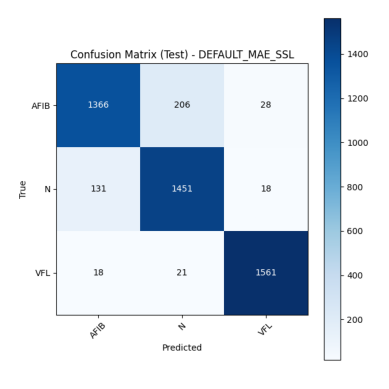

Finished. Outputs saved inside MAE_SSL_RHYTHM/Default_MAE_SSL folder.


In [11]:
print('\n' + '='*80)
print('Starting DEFAULT MAE+SSL 5-Fold training for RHYTHM classification...')
print('='*80)

default_cfg = DEFAULT_CONFIG
folds_default = run_5fold_training(default_cfg, default_run_name='default_mae_ssl')
summarize_folds(folds_default, 'DEFAULT_MAE_SSL')

all_preds = []
all_trues = []
for f, d in folds_default.items():
    all_preds.extend(d['preds'])
    all_trues.extend(d['trues'])

classification_report_and_cm(all_trues, all_preds, DEFAULT_CONFIG['dataset']['classes'], 'DEFAULT_MAE_SSL')

print('Finished. Outputs saved inside MAE_SSL_RHYTHM/Default_MAE_SSL folder.')

## 8.2. Hyperparameter Tuning MAE+SSL (Hyperparameter tuning + 5-Fold Training)

[I 2025-11-06 06:12:47,297] A new study created in memory with name: no-name-786f9a63-3268-4a65-9827-3a071ca1c6aa



Starting HYPERPARAMETER TUNING for RHYTHM classification...


/tmp/ipykernel_19/3061727314.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
/tmp/ipykernel_19/3061727314.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
/tmp/ipykernel_19/3061727314.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  mask_ratio = trial.suggest_uniform('mask_ratio', 0.1, 0.75)
/tmp/ipykernel_19/3061727314.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will b

Best trial: {'lr': 0.0006949810157401428, 'weight_decay': 1.0665286175832182e-06, 'dim': 128, 'n_heads': 8, 'mask_ratio': 0.39762648893189373, 'ssl_weight': 0.50326464590612, 'temperature': 0.09527167563996856}
Running 5-fold with HPO best config...

Starting fold 1 - MAE+SSL Rhythm Training

--- Phase 1: SSL Pretraining (20 epochs) ---


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Pretrain Epoch 1/20: contrastive_loss=2.8056 recon_loss=0.0141
Pretrain Epoch 2/20: contrastive_loss=1.6213 recon_loss=0.0040
Pretrain Epoch 3/20: contrastive_loss=1.2444 recon_loss=0.0023
Pretrain Epoch 4/20: contrastive_loss=0.9919 recon_loss=0.0015
Pretrain Epoch 5/20: contrastive_loss=0.8806 recon_loss=0.0010
Pretrain Epoch 6/20: contrastive_loss=0.7893 recon_loss=0.0009
Pretrain Epoch 7/20: contrastive_loss=0.6942 recon_loss=0.0006
Pretrain Epoch 8/20: contrastive_loss=0.6424 recon_loss=0.0005
Pretrain Epoch 9/20: contrastive_loss=0.5597 recon_loss=0.0004
Pretrain Epoch 10/20: contrastive_loss=0.5232 recon_loss=0.0004
Pretrain Epoch 11/20: contrastive_loss=0.4576 recon_loss=0.0003
Pretrain Epoch 12/20: contrastive_loss=0.4543 recon_loss=0.0003
Pretrain Epoch 13/20: contrastive_loss=0.4229 recon_loss=0.0002
Pretrain Epoch 14/20: contrastive_loss=0.4125 recon_loss=0.0002
Pretrain Epoch 15/20: contrastive_loss=0.3794 recon_loss=0.0002
Pretrain Epoch 16/20: contrastive_loss=0.3475 rec

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Pretrain Epoch 1/20: contrastive_loss=2.6364 recon_loss=0.0135
Pretrain Epoch 2/20: contrastive_loss=1.7003 recon_loss=0.0037
Pretrain Epoch 3/20: contrastive_loss=1.2423 recon_loss=0.0021
Pretrain Epoch 4/20: contrastive_loss=1.1038 recon_loss=0.0015
Pretrain Epoch 5/20: contrastive_loss=0.9416 recon_loss=0.0011
Pretrain Epoch 6/20: contrastive_loss=0.8278 recon_loss=0.0008
Pretrain Epoch 7/20: contrastive_loss=0.7221 recon_loss=0.0007
Pretrain Epoch 8/20: contrastive_loss=0.6544 recon_loss=0.0006
Pretrain Epoch 9/20: contrastive_loss=0.5717 recon_loss=0.0005
Pretrain Epoch 10/20: contrastive_loss=0.5434 recon_loss=0.0004
Pretrain Epoch 11/20: contrastive_loss=0.5056 recon_loss=0.0003
Pretrain Epoch 12/20: contrastive_loss=0.5109 recon_loss=0.0003
Pretrain Epoch 13/20: contrastive_loss=0.4403 recon_loss=0.0002
Pretrain Epoch 14/20: contrastive_loss=0.3785 recon_loss=0.0002
Pretrain Epoch 15/20: contrastive_loss=0.3789 recon_loss=0.0002
Pretrain Epoch 16/20: contrastive_loss=0.3670 rec

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Pretrain Epoch 1/20: contrastive_loss=2.6747 recon_loss=0.0129
Pretrain Epoch 2/20: contrastive_loss=1.6146 recon_loss=0.0033
Pretrain Epoch 3/20: contrastive_loss=1.2566 recon_loss=0.0017
Pretrain Epoch 4/20: contrastive_loss=1.0379 recon_loss=0.0012
Pretrain Epoch 5/20: contrastive_loss=0.9269 recon_loss=0.0009
Pretrain Epoch 6/20: contrastive_loss=0.8661 recon_loss=0.0007
Pretrain Epoch 7/20: contrastive_loss=0.8079 recon_loss=0.0006
Pretrain Epoch 8/20: contrastive_loss=0.6574 recon_loss=0.0004
Pretrain Epoch 9/20: contrastive_loss=0.6177 recon_loss=0.0004
Pretrain Epoch 10/20: contrastive_loss=0.5597 recon_loss=0.0003
Pretrain Epoch 11/20: contrastive_loss=0.5006 recon_loss=0.0003
Pretrain Epoch 12/20: contrastive_loss=0.4805 recon_loss=0.0002
Pretrain Epoch 13/20: contrastive_loss=0.4706 recon_loss=0.0002
Pretrain Epoch 14/20: contrastive_loss=0.4353 recon_loss=0.0002
Pretrain Epoch 15/20: contrastive_loss=0.4015 recon_loss=0.0002
Pretrain Epoch 16/20: contrastive_loss=0.3808 rec

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Pretrain Epoch 1/20: contrastive_loss=2.7707 recon_loss=0.0147
Pretrain Epoch 2/20: contrastive_loss=1.7992 recon_loss=0.0035
Pretrain Epoch 3/20: contrastive_loss=1.2952 recon_loss=0.0023
Pretrain Epoch 4/20: contrastive_loss=1.0576 recon_loss=0.0016
Pretrain Epoch 5/20: contrastive_loss=0.8631 recon_loss=0.0012
Pretrain Epoch 6/20: contrastive_loss=0.7792 recon_loss=0.0009
Pretrain Epoch 7/20: contrastive_loss=0.6613 recon_loss=0.0007
Pretrain Epoch 8/20: contrastive_loss=0.5688 recon_loss=0.0006
Pretrain Epoch 9/20: contrastive_loss=0.5218 recon_loss=0.0005
Pretrain Epoch 10/20: contrastive_loss=0.4867 recon_loss=0.0004
Pretrain Epoch 11/20: contrastive_loss=0.4520 recon_loss=0.0003
Pretrain Epoch 12/20: contrastive_loss=0.4397 recon_loss=0.0003
Pretrain Epoch 13/20: contrastive_loss=0.3952 recon_loss=0.0003
Pretrain Epoch 14/20: contrastive_loss=0.3427 recon_loss=0.0002
Pretrain Epoch 15/20: contrastive_loss=0.3511 recon_loss=0.0002
Pretrain Epoch 16/20: contrastive_loss=0.3149 rec

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Pretrain Epoch 1/20: contrastive_loss=2.6613 recon_loss=0.0142
Pretrain Epoch 2/20: contrastive_loss=1.6618 recon_loss=0.0034
Pretrain Epoch 3/20: contrastive_loss=1.2934 recon_loss=0.0020
Pretrain Epoch 4/20: contrastive_loss=1.0713 recon_loss=0.0015
Pretrain Epoch 5/20: contrastive_loss=0.9226 recon_loss=0.0011
Pretrain Epoch 6/20: contrastive_loss=0.8134 recon_loss=0.0009
Pretrain Epoch 7/20: contrastive_loss=0.6668 recon_loss=0.0007
Pretrain Epoch 8/20: contrastive_loss=0.6189 recon_loss=0.0006
Pretrain Epoch 9/20: contrastive_loss=0.6224 recon_loss=0.0005
Pretrain Epoch 10/20: contrastive_loss=0.5402 recon_loss=0.0004
Pretrain Epoch 11/20: contrastive_loss=0.5133 recon_loss=0.0003
Pretrain Epoch 12/20: contrastive_loss=0.4451 recon_loss=0.0003
Pretrain Epoch 13/20: contrastive_loss=0.4538 recon_loss=0.0002
Pretrain Epoch 14/20: contrastive_loss=0.4158 recon_loss=0.0002
Pretrain Epoch 15/20: contrastive_loss=0.4179 recon_loss=0.0002
Pretrain Epoch 16/20: contrastive_loss=0.3977 rec

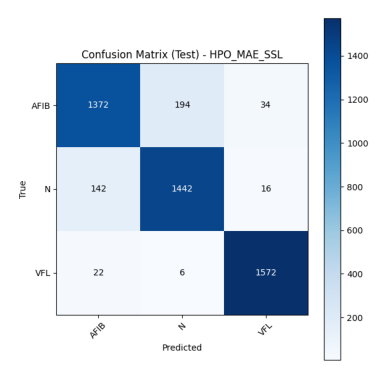


=== Comparison ===
DEFAULT mean acc: 0.9120833333333334
HPO mean acc: 0.91375


In [12]:
if OPTUNA_AVAILABLE:
    print('\n' + '='*80)
    print('Starting HYPERPARAMETER TUNING for RHYTHM classification...')
    print('='*80)
    hpo_cfg = json.loads(json.dumps(DEFAULT_CONFIG))
    hpo_cfg, study = run_hyperparam_search(hpo_cfg, n_trials=50, timeout=None)
    print('Running 5-fold with HPO best config...')
    folds_hpo = run_5fold_training(hpo_cfg, default_run_name='hpo_mae_ssl')
    summarize_folds(folds_hpo, 'HPO_MAE_SSL')

    all_preds_hpo = []
    all_trues_hpo = []
    for f, d in folds_hpo.items():
        all_preds_hpo.extend(d['preds'])
        all_trues_hpo.extend(d['trues'])
    classification_report_and_cm(all_trues_hpo, all_preds_hpo, DEFAULT_CONFIG['dataset']['classes'], 'HPO_MAE_SSL')

else:
    print('Optuna not available. Skipping HPO run.')

print('\n=== Comparison ===')
print('DEFAULT mean acc:', np.mean([d['val_acc'] for d in folds_default.values()]))
if OPTUNA_AVAILABLE and 'folds_hpo' in locals():
    print('HPO mean acc:', np.mean([d['val_acc'] for d in folds_hpo.values()]))

In [13]:
print('\n=== Comparison ===')
print('DEFAULT mean acc:', np.mean([d['val_acc'] for d in folds_default.values()]))
print('HPO mean acc:', np.mean([d['val_acc'] for d in folds_hpo.values()]))


=== Comparison ===
DEFAULT mean acc: 0.9120833333333334
HPO mean acc: 0.91375


# 9. Evaluate

## 9.1. Evaluate Utils

In [14]:
def plot_training_history_per_fold(fold_results, model_name, save_prefix):
    """Plot training history (loss and accuracy) for each fold separately"""
    
    matrix_dir = OUTPUT_DIRS['default_matrix'] if save_prefix.lower() == 'default_mae_ssl_rhythm' else \
        OUTPUT_DIRS['hpo_matrix'] if save_prefix.lower() == 'hpo_mae_ssl_rhythm' else OUTPUT_DIRS['outputs']

    history_dir = OUTPUT_DIRS['default_history'] if save_prefix.lower() == 'default_mae_ssl_rhythm' else \
        OUTPUT_DIRS['hpo_history'] if save_prefix.lower() == 'hpo_mae_ssl_rhythm' else OUTPUT_DIRS['outputs']
    
    n_folds = len(fold_results)
    
    fig, axes = plt.subplots(2, n_folds, figsize=(5*n_folds, 10))
    if n_folds == 1:
        axes = axes.reshape(-1, 1)
    
    fig.suptitle(f'{model_name} - Training History per Fold\n\n', fontsize=16, y=0.95)
    
    for i, (fold_num, fold_data) in enumerate(fold_results.items()):
        history = fold_data['history']
        epochs = range(1, len(history['train_loss']) + 1)
        
        # Plot Loss
        axes[0, i].plot(epochs, history['train_loss'], 'b-', label='Train Loss', marker='o', markersize=3)
        axes[0, i].plot(epochs, history['val_loss'], 'red', label='Val Loss', marker='s', markersize=3)
        axes[0, i].set_title(f'Fold {fold_num} - Loss')
        axes[0, i].set_xlabel('Epoch')
        axes[0, i].set_ylabel('Loss')
        axes[0, i].legend()
        axes[0, i].grid(True, alpha=0.3)
        
        # Plot Accuracy
        axes[1, i].plot(epochs, history['train_acc'], 'b-', label='Train Acc', marker='o', markersize=3)
        axes[1, i].plot(epochs, history['val_acc'], 'red', label='Val Acc', marker='s', markersize=3)
        axes[1, i].set_title(f'Fold {fold_num} - Accuracy')
        axes[1, i].set_xlabel('Epoch')
        axes[1, i].set_ylabel('Accuracy')
        axes[1, i].legend()
        axes[1, i].grid(True, alpha=0.3)
        axes[1, i].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig(f'{history_dir}/{save_prefix}_training_history_per_fold.png', dpi=300, bbox_inches='tight')
    plt.close()


def get_fold_predictions_detailed(fold_results, cfg, fold_num, dataset_type='train'):
    """Get predictions and true labels for a specific fold and dataset type"""
    device = cfg['training']['device']
    dataset = ECGRhythmDataset(cfg['dataset']['train_dirs'], cfg['dataset']['classes'])
    
    X = list(range(len(dataset)))
    y = dataset.labels
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=cfg['seed'])
    
    for current_fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        if current_fold + 1 == fold_num:
            if dataset_type == 'train':
                subset_idx = train_idx
            else:
                subset_idx = val_idx
                
            subset = Subset(dataset, subset_idx)
            loader = DataLoader(subset, batch_size=cfg['training']['batch_size'], 
                              shuffle=False, collate_fn=collate_ecg, 
                              num_workers=cfg['training']['num_workers'])
            
            sample_x, _ = dataset[subset_idx[0]]
            L = sample_x.shape[0]
            patch_size = cfg['model']['patch_size']
            num_patches = (L + patch_size - 1) // patch_size
            
            model = TransformerMAE_SSL(num_patches=num_patches, patch_size=patch_size, cfg=cfg['model']).to(device)
            model.load_state_dict(fold_results[fold_num]['model_state_dict'])
            
            _, _, preds, trues = validate(model, loader, device)
            return preds, trues
    
    return [], []


def plot_confusion_matrix_heatmap(y_true, y_pred, classes, title, save_path, cmap='Blues'):
    """Create confusion matrix heatmap"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, 
                xticklabels=classes, yticklabels=classes,
                cbar_kws={'label': 'Count'})
    
    plt.title(title, fontsize=14, pad=20)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    return cm


def generate_classification_reports_per_fold(fold_results, cfg, classes, model_name, save_prefix):
    """Generate classification reports for each fold (train and validation)"""
    reports = {
        'train': {},
        'val': {}
    }
    
    print(f"\n{'='*80}")
    print(f"{model_name} - CLASSIFICATION REPORTS PER FOLD")
    print('='*80)
    
    for fold_num in fold_results.keys():
        print(f"\n### FOLD {fold_num} ###")
        
        train_preds, train_trues = get_fold_predictions_detailed(fold_results, cfg, fold_num, 'train')
        if len(train_preds) > 0:
            train_report = classification_report(train_trues, train_preds, target_names=classes, output_dict=True)
            reports['train'][fold_num] = train_report
            
            print(f"\n--- FOLD {fold_num} TRAIN CLASSIFICATION REPORT ---")
            print(classification_report(train_trues, train_preds, target_names=classes))
        
        val_preds = fold_results[fold_num]['preds']
        val_trues = fold_results[fold_num]['trues']
        val_report = classification_report(val_trues, val_preds, target_names=classes, output_dict=True)
        reports['val'][fold_num] = val_report
        
        print(f"\n--- FOLD {fold_num} VALIDATION CLASSIFICATION REPORT ---")
        print(classification_report(val_trues, val_preds, target_names=classes))
    
    return reports


def generate_confusion_matrices_per_fold(fold_results, cfg, classes, model_name, save_prefix):
    """Generate confusion matrix for each fold (train and validation)"""
    print(f"\n{'='*80}")
    print(f"{model_name} - CONFUSION MATRIX PER FOLD")
    print('='*80)

    models_dir = OUTPUT_DIRS['default_models'] if save_prefix.lower() == 'default_mae_ssl_rhythm' else \
        OUTPUT_DIRS['hpo_models'] if save_prefix.lower() == 'hpo_mae_ssl_rhythm' else 'outputs'
    
    confusion_matrices = {
        'train': {},
        'val': {}
    }
    
    matrix_dir = OUTPUT_DIRS['default_matrix'] if save_prefix.lower() == 'default_mae_ssl_rhythm' else \
        OUTPUT_DIRS['hpo_matrix'] if save_prefix.lower() == 'hpo_mae_ssl_rhythm' else 'outputs'
    
    for fold_num in fold_results.keys():
        print(f"\n### FOLD {fold_num} CONFUSION MATRIX ###")
        
        train_preds, train_trues = get_fold_predictions_detailed(fold_results, cfg, fold_num, 'train')
        if len(train_preds) > 0:
            train_cm = plot_confusion_matrix_heatmap(
                train_trues, train_preds, classes,
                f'{model_name} - Fold {fold_num} Train Confusion Matrix',
                f'{matrix_dir}/{save_prefix}_fold{fold_num}_train_confusion_matrix.png',
                cmap='Greens'
            )
            confusion_matrices['train'][fold_num] = train_cm
            print(f"Fold {fold_num} Train Confusion Matrix saved.")
            
            img = mpimg.imread(f'{matrix_dir}/{save_prefix}_fold{fold_num}_train_confusion_matrix.png')
            plt.imshow(img)
            plt.axis('off')
            plt.show()
        
        val_preds = fold_results[fold_num]['preds']
        val_trues = fold_results[fold_num]['trues']
        val_cm = plot_confusion_matrix_heatmap(
            val_trues, val_preds, classes,
            f'{model_name} - Fold {fold_num} Validation Confusion Matrix',
            f'{matrix_dir}/{save_prefix}_fold{fold_num}_val_confusion_matrix.png',
            cmap='Reds'
        )
        confusion_matrices['val'][fold_num] = val_cm
        print(f"Fold {fold_num} Validation Confusion Matrix saved.")
        
        img = mpimg.imread(f'{matrix_dir}/{save_prefix}_fold{fold_num}_val_confusion_matrix.png')
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    
    return confusion_matrices


def evaluate_test_set_for_fold(model_path, cfg, test_dirs, classes, fold_num, model_name, save_prefix):
    """Evaluate a specific fold model on test set"""
    device = cfg['training']['device']

    matrix_dir = OUTPUT_DIRS['default_matrix'] if save_prefix.lower() == 'default_mae_ssl_rhythm' else \
        OUTPUT_DIRS['hpo_matrix'] if save_prefix.lower() == 'hpo_mae_ssl_rhythm' else 'outputs'
    
    test_dataset = ECGRhythmDataset(test_dirs, classes)
    test_loader = DataLoader(test_dataset, batch_size=cfg['training']['batch_size'], 
                            shuffle=False, collate_fn=collate_ecg, 
                            num_workers=cfg['training']['num_workers'])
    
    sample_x, _ = test_dataset[0]
    L = sample_x.shape[0]
    patch_size = cfg['model']['patch_size']
    num_patches = (L + patch_size - 1) // patch_size
    
    model = TransformerMAE_SSL(num_patches=num_patches, patch_size=patch_size, cfg=cfg['model']).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    test_loss, test_acc, test_preds, test_trues = validate(model, test_loader, device)
    
    print(f"\n--- FOLD {fold_num} TEST CLASSIFICATION REPORT ---")
    test_report = classification_report(test_trues, test_preds, target_names=classes)
    print(test_report)
    
    test_cm = plot_confusion_matrix_heatmap(
        test_trues, test_preds, classes,
        f'{model_name} - Fold {fold_num} Test Confusion Matrix',
        f'{matrix_dir}/{save_prefix}_fold{fold_num}_test_confusion_matrix.png',
        cmap='Greens'
    )
    print(f"Fold {fold_num} Test Confusion Matrix saved.")

    img = mpimg.imread(f'{matrix_dir}/{save_prefix}_fold{fold_num}_test_confusion_matrix.png')
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    return {
        'loss': test_loss,
        'accuracy': test_acc,
        'predictions': test_preds,
        'true_labels': test_trues,
        'classification_report': classification_report(test_trues, test_preds, target_names=classes, output_dict=True),
        'confusion_matrix': test_cm
    }


def find_best_fold(fold_results):
    """Find best fold based on validation accuracy"""
    best_fold = None
    best_acc = 0
    
    for fold, data in fold_results.items():
        if data['val_acc'] > best_acc:
            best_acc = data['val_acc']
            best_fold = fold
    
    return best_fold, best_acc


def evaluate_model_on_test_set(model_path, cfg, test_dirs, classes):
    """Evaluate model on test set"""
    device = cfg['training']['device']
    
    test_dataset = ECGRhythmDataset(test_dirs, classes)
    test_loader = DataLoader(test_dataset, batch_size=cfg['training']['batch_size'], 
                            shuffle=False, collate_fn=collate_ecg, 
                            num_workers=cfg['training']['num_workers'])
    
    sample_x, _ = test_dataset[0]
    L = sample_x.shape[0]
    patch_size = cfg['model']['patch_size']
    num_patches = (L + patch_size - 1) // patch_size
    
    model = TransformerMAE_SSL(num_patches=num_patches, patch_size=patch_size, cfg=cfg['model']).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    test_loss, test_acc, test_preds, test_trues = validate(model, test_loader, device)
    
    return test_loss, test_acc, test_preds, test_trues


def get_train_predictions(fold_results, cfg):
    """Get predictions for training set from each fold"""
    device = cfg['training']['device']
    dataset = ECGRhythmDataset(cfg['dataset']['train_dirs'], cfg['dataset']['classes'])
    
    all_train_preds = []
    all_train_trues = []
    
    for fold, fold_data in fold_results.items():
        X = list(range(len(dataset)))
        y = dataset.labels
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=cfg['seed'])
        
        for current_fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            if current_fold + 1 == fold:
                train_subset = Subset(dataset, train_idx)
                train_loader = DataLoader(train_subset, batch_size=cfg['training']['batch_size'], 
                                        shuffle=False, collate_fn=collate_ecg, 
                                        num_workers=cfg['training']['num_workers'])
                
                sample_x, _ = dataset[train_idx[0]]
                L = sample_x.shape[0]
                patch_size = cfg['model']['patch_size']
                num_patches = (L + patch_size - 1) // patch_size
                
                model = TransformerMAE_SSL(num_patches=num_patches, patch_size=patch_size, cfg=cfg['model']).to(device)
                model.load_state_dict(fold_data['model_state_dict'])
                
                _, _, train_preds, train_trues = validate(model, train_loader, device)
                all_train_preds.extend(train_preds)
                all_train_trues.extend(train_trues)
                break
    
    return all_train_preds, all_train_trues


def display_fold_metrics(fold_results, model_name):
    """Display metrics for each fold"""
    print(f"\n=== {model_name} - Metrics per Fold ===")
    print("Fold | Val Acc | Val Loss | Train Acc (Last) | Train Loss (Last)")
    print("-" * 70)
    
    for fold, data in fold_results.items():
        history = data['history']
        last_train_acc = history['val_acc'][-1] if history['val_acc'] else "N/A"
        last_train_loss = history['train_loss'][-1] if history['train_loss'] else "N/A"
        
        print(f"{fold:4d} | {data['val_acc']:7.4f} | {data['val_loss']:8.4f} | {last_train_acc:13.4f} | {last_train_loss:15.4f}")


def compare_configurations(default_cfg, hpo_cfg=None, output_dir=None):
    """Compare default and HPO configurations, then export to Excel"""
    print("\n=== Parameter Comparison ===")
    print("Parameter                | Default Config | Best HPO Config")
    print("-" * 60)
    
    data = []
    
    def add_row(param, default_value, hpo_value):
        data.append({
            'Parameter': param,
            'Default Config': default_value,
            'Best HPO Config': hpo_value if hpo_cfg else 'N/A'
        })
    
    add_row("Device", default_cfg['training']['device'], hpo_cfg['training']['device'] if hpo_cfg else None)
    add_row("Epoch", default_cfg['training']['num_epochs'], hpo_cfg['training']['num_epochs'] if hpo_cfg else None)
    add_row("Batch Size", default_cfg['training']['batch_size'], hpo_cfg['training']['batch_size'] if hpo_cfg else None)
    add_row("Learning Rate", default_cfg['training']['learning_rate'], hpo_cfg['training']['learning_rate'] if hpo_cfg else None)
    add_row("Weight Decay", default_cfg['training']['weight_decay'], hpo_cfg['training']['weight_decay'] if hpo_cfg else None)
    add_row("Model Dimension", default_cfg['model']['dim'], hpo_cfg['model']['dim'] if hpo_cfg else None)
    add_row("Number of Heads", default_cfg['model']['n_heads'], hpo_cfg['model']['n_heads'] if hpo_cfg else None)
    add_row("Mask Ratio", default_cfg['model']['mask_ratio'], hpo_cfg['model']['mask_ratio'] if hpo_cfg else None)
    add_row("Dropout", default_cfg['model']['dropout'], hpo_cfg['model']['dropout'] if hpo_cfg else None)

    for row in data:
        print(f"{row['Parameter']:<24} | {str(row['Default Config']):14s} | {str(row['Best HPO Config']):15s}")

    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(output_dir, "parameter_comparison_rhythm.xlsx")
        df = pd.DataFrame(data)
        df.to_excel(output_path, index=False)
        print(f"\n✅ Parameter comparison saved to: {output_path}")


def calculate_detailed_metrics_updated(y_true, y_pred, classes):
    """Calculate detailed metrics: Per-Class Accuracy, Sensitivity, Specificity, F1-Score"""
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None, labels=range(len(classes)))
    
    cm = confusion_matrix(y_true, y_pred)
    
    per_class_accuracy = []
    specificity = []
    
    for i in range(len(classes)):
        total = cm.sum()
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
 
        per_class_acc = (tp+tn) / (total) if (tp + fn) > 0 else 0
        per_class_accuracy.append(per_class_acc)
        
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity.append(spec)
    
    overall_accuracy = np.mean(per_class_accuracy)
    
    macro_sensitivity = np.mean(recall)
    macro_specificity = np.mean(specificity)
    macro_f1 = np.mean(f1)
    
    return {
        'per_class': {
            'accuracy': per_class_accuracy,
            'sensitivity': recall,
            'specificity': specificity,
            'f1_score': f1
        },
        'overall': {
            'accuracy': overall_accuracy,
            'sensitivity': macro_sensitivity,
            'specificity': macro_specificity,
            'f1_score': macro_f1
        }
    }


def get_test_metrics_for_best_fold(fold_results, cfg, classes, model_name, save_prefix):
    """Get test metrics for the best fold"""

    models_dir = OUTPUT_DIRS['default_models'] if save_prefix.lower() == 'default_mae_ssl' else \
        OUTPUT_DIRS['hpo_models'] if save_prefix.lower() == 'hpo_mae_ssl' else OUTPUT_DIRS['outputs']
    
    best_fold = None
    best_acc = 0
    for fold, data in fold_results.items():
        if data['val_acc'] > best_acc:
            best_acc = data['val_acc']
            best_fold = fold
    
    if best_fold is None:
        return None, None
        
    device = cfg['training']['device']
    test_dataset = ECGRhythmDataset(cfg['dataset']['test_dirs'], classes)
    test_loader = DataLoader(test_dataset, batch_size=cfg['training']['batch_size'], 
                            shuffle=False, collate_fn=collate_ecg, 
                            num_workers=cfg['training']['num_workers'])
    
    sample_x, _ = test_dataset[0]
    L = sample_x.shape[0]
    patch_size = cfg['model']['patch_size']
    num_patches = (L + patch_size - 1) // patch_size
    
    model = TransformerMAE_SSL(num_patches=num_patches, patch_size=patch_size, cfg=cfg['model']).to(device)
    model_path = f'{models_dir}/{save_prefix}_fold{best_fold}.pth'
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    _, _, test_preds, test_trues = validate(model, test_loader, device)
    
    metrics = calculate_detailed_metrics_updated(test_trues, test_preds, classes)
    
    results = []
    
    for i, class_name in enumerate(classes):
        results.append({
            'Best_Fold': best_fold,
            'Class': class_name,
            'Accuracy': f"{metrics['per_class']['accuracy'][i]:.4f}",
            'Sensitivity': f"{metrics['per_class']['sensitivity'][i]:.4f}",
            'Specificity': f"{metrics['per_class']['specificity'][i]:.4f}",
            'F1-Score': f"{metrics['per_class']['f1_score'][i]:.4f}"
        })
    
    results.append({
        'Best_Fold': best_fold,
        'Class': 'All',
        'Accuracy': f"{metrics['overall']['accuracy']:.4f}",
        'Sensitivity': f"{metrics['overall']['sensitivity']:.4f}",
        'Specificity': f"{metrics['overall']['specificity']:.4f}",
        'F1-Score': f"{metrics['overall']['f1_score']:.4f}"
    })
    
    return pd.DataFrame(results), best_fold


def get_fold_predictions_and_trues(fold_results, cfg, fold_num, dataset_type='train'):
    """Get predictions and true labels for a specific fold and dataset type"""
    device = cfg['training']['device']
    dataset = ECGRhythmDataset(cfg['dataset']['train_dirs'], cfg['dataset']['classes'])
    
    X = list(range(len(dataset)))
    y = dataset.labels
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=cfg['seed'])
    
    for current_fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        if current_fold + 1 == fold_num:
            if dataset_type == 'train':
                subset_idx = train_idx
            else:
                subset_idx = val_idx
                
            subset = Subset(dataset, subset_idx)
            loader = DataLoader(subset, batch_size=cfg['training']['batch_size'], 
                              shuffle=False, collate_fn=collate_ecg, 
                              num_workers=cfg['training']['num_workers'])
            
            sample_x, _ = dataset[subset_idx[0]]
            L = sample_x.shape[0]
            patch_size = cfg['model']['patch_size']
            num_patches = (L + patch_size - 1) // patch_size
            
            model = TransformerMAE_SSL(num_patches=num_patches, patch_size=patch_size, cfg=cfg['model']).to(device)
            model.load_state_dict(fold_results[fold_num]['model_state_dict'])
            
            _, _, preds, trues = validate(model, loader, device)
            return preds, trues
    
    return [], []


def create_detailed_metrics_table_updated(fold_results, cfg, model_name, classes):
    """Create detailed metrics table for all folds with updated per-class accuracy calculation"""
    results = []
    
    for fold_num in fold_results.keys():
        print(f"Processing {model_name} - Fold {fold_num}...")
        
        train_preds, train_trues = get_fold_predictions_and_trues(fold_results, cfg, fold_num, 'train')
        
        if len(train_preds) > 0 and len(train_trues) > 0:
            metrics = calculate_detailed_metrics_updated(train_trues, train_preds, classes)
            
            for i, class_name in enumerate(classes):
                results.append({
                    'Fold': f'Fold {fold_num}',
                    'Class': class_name,
                    'Accuracy': f"{metrics['per_class']['accuracy'][i]:.4f}",
                    'Sensitivity': f"{metrics['per_class']['sensitivity'][i]:.4f}",
                    'Specificity': f"{metrics['per_class']['specificity'][i]:.4f}",
                    'F1-Score': f"{metrics['per_class']['f1_score'][i]:.4f}"
                })
            
            results.append({
                'Fold': f'Fold {fold_num}',
                'Class': 'All',
                'Accuracy': f"{metrics['overall']['accuracy']:.4f}",
                'Sensitivity': f"{metrics['overall']['sensitivity']:.4f}",
                'Specificity': f"{metrics['overall']['specificity']:.4f}",
                'F1-Score': f"{metrics['overall']['f1_score']:.4f}"
            })
    
    all_train_preds = []
    all_train_trues = []
    
    for fold_num in fold_results.keys():
        train_preds, train_trues = get_fold_predictions_and_trues(fold_results, cfg, fold_num, 'train')
        all_train_preds.extend(train_preds)
        all_train_trues.extend(train_trues)
    
    if len(all_train_preds) > 0:
        overall_metrics = calculate_detailed_metrics_updated(all_train_trues, all_train_preds, classes)
        results.append({
            'Fold': 'Across 5 folds',
            'Class': 'All',
            'Accuracy': f"{overall_metrics['overall']['accuracy']:.4f}",
            'Sensitivity': f"{overall_metrics['overall']['sensitivity']:.4f}",
            'Specificity': f"{overall_metrics['overall']['specificity']:.4f}",
            'F1-Score': f"{overall_metrics['overall']['f1_score']:.4f}"
        })
    
    return pd.DataFrame(results)


def display_metrics_table(df, title):
    """Display metrics table in a formatted way"""
    print(f"\n{'='*80}")
    print(f"{title:^80}")
    print('='*80)
    
    current_fold = None
    for _, row in df.iterrows():
        if row['Fold'] != current_fold:
            if current_fold is not None:
                print('-'*80)
            current_fold = row['Fold']
            print(f"\n{row['Fold']:<15} {row['Class']:<5} {row['Accuracy']:<10} {row['Sensitivity']:<12} {row['Specificity']:<12} {row['F1-Score']:<10}")
        else:
            print(f"{'':15} {row['Class']:<5} {row['Accuracy']:<10} {row['Sensitivity']:<12} {row['Specificity']:<12} {row['F1-Score']:<10}")


def save_metrics_to_excel_enhanced_updated(df_default, df_hpo=None, fold_results_default=None, fold_results_hpo=None, 
                                         default_cfg=None, hpo_cfg=None, classes=None, 
                                         filename=f'{OUTPUT_DIRS["outputs"]}/detailed_metrics_comparison_rhythm.xlsx'):
    """Save metrics tables to Excel file with additional sheets including test results for best folds"""
    
    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        df_default.to_excel(writer, sheet_name='Default_Train_MAE_SSL_RHYTHM', index=False)
        if df_hpo is not None:
            df_hpo.to_excel(writer, sheet_name='Tuning_Train_MAE_SSL_RHYTHM', index=False)
        
        if fold_results_default is not None and default_cfg is not None and classes is not None:
            print("Generating Default_Test_MAE_SSL_RHYTHM sheet...")
            df_default_test, best_fold_default = get_test_metrics_for_best_fold(
                fold_results_default, default_cfg, classes, "Default MAE+SSL Rhythm", "default_mae_ssl"
            )
            if df_default_test is not None:
                df_default_test.to_excel(writer, sheet_name='Default_Test_MAE_SSL_RHYTHM', index=False)
                print(f"Default_Test_MAE_SSL_RHYTHM sheet created successfully for best fold {best_fold_default}.")
            else:
                print("Failed to create Default_Test_MAE_SSL_RHYTHM sheet.")
        
        if fold_results_hpo is not None and hpo_cfg is not None and classes is not None:
            print("Generating Tuning_Test_MAE_SSL_RHYTHM sheet...")
            df_hpo_test, best_fold_hpo = get_test_metrics_for_best_fold(
                fold_results_hpo, hpo_cfg, classes, "HPO MAE+SSL Rhythm", "hpo_mae_ssl"
            )
            if df_hpo_test is not None:
                df_hpo_test.to_excel(writer, sheet_name='Tuning_Test_MAE_SSL_RHYTHM', index=False)
                print(f"Tuning_Test_MAE_SSL_RHYTHM sheet created successfully for best fold {best_fold_hpo}.")
            else:
                print("Failed to create Tuning_Test_MAE_SSL_RHYTHM sheet.")
    
    print(f"Enhanced metrics with updated accuracy calculation saved to {filename}")

## 9.2. Best Fold - Default MAE+SSL & HPO MAE+SSL

In [15]:
best_fold_default, best_acc_default = find_best_fold(folds_default)
print(f"\n=> Best Fold (Default MAE Rhythm): Fold {best_fold_default} with accuracy {best_acc_default:.4f}")

display_fold_metrics(folds_default, "DEFAULT MAE RHYTHM")

best_model_path = f'{OUTPUT_DIRS["default_models"]}/default_mae_ssl_fold{best_fold_default}.pth'
test_loss_default, test_acc_default, test_preds_default, test_trues_default = evaluate_model_on_test_set(
    best_model_path, default_cfg, DEFAULT_CONFIG['dataset']['test_dirs'], DEFAULT_CONFIG['dataset']['classes']
)

if OPTUNA_AVAILABLE and 'folds_hpo' in locals():
    print()
    best_fold_hpo, best_acc_hpo = find_best_fold(folds_hpo)
    print(f"\n=> Best Fold (HPO MAE Rhythm): Fold {best_fold_hpo} with accuracy {best_acc_hpo:.4f}")
    
    display_fold_metrics(folds_hpo, "HPO MAE RHYTHM")

    best_model_path_hpo = f'{OUTPUT_DIRS["hpo_models"]}/hpo_mae_ssl_fold{best_fold_hpo}.pth'
    test_loss_hpo, test_acc_hpo, test_preds_hpo, test_trues_hpo = evaluate_model_on_test_set(
        best_model_path_hpo, hpo_cfg, DEFAULT_CONFIG['dataset']['test_dirs'], DEFAULT_CONFIG['dataset']['classes']
    )
    print(f"\n\n\n=== IMPROVEMENT SUMMARY ===")
    print(f"Improvement: {((best_acc_hpo - best_acc_default) / best_acc_default * 100):+.2f}% (validation)")
    print(f"Improvement: {((test_acc_hpo - test_acc_default) / test_acc_default * 100):+.2f}% (test)\n")




=> Best Fold (Default MAE Rhythm): Fold 5 with accuracy 0.9187

=== DEFAULT MAE RHYTHM - Metrics per Fold ===
Fold | Val Acc | Val Loss | Train Acc (Last) | Train Loss (Last)
----------------------------------------------------------------------
   1 |  0.8958 |   0.3115 |        0.8958 |          0.0895
   2 |  0.9135 |   0.2873 |        0.9135 |          0.1072
   3 |  0.9177 |   0.2850 |        0.9177 |          0.0752
   4 |  0.9146 |   0.2268 |        0.9146 |          0.1106
   5 |  0.9187 |   0.2512 |        0.9187 |          0.0942


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(




=> Best Fold (HPO MAE Rhythm): Fold 4 with accuracy 0.9250

=== HPO MAE RHYTHM - Metrics per Fold ===
Fold | Val Acc | Val Loss | Train Acc (Last) | Train Loss (Last)
----------------------------------------------------------------------
   1 |  0.9167 |   0.2698 |        0.9167 |          0.0673
   2 |  0.8969 |   0.3208 |        0.8969 |          0.0897
   3 |  0.9177 |   0.3105 |        0.9177 |          0.0807
   4 |  0.9250 |   0.2343 |        0.9250 |          0.0590
   5 |  0.9125 |   0.3436 |        0.9125 |          0.0385


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(





=== IMPROVEMENT SUMMARY ===
Improvement: +0.68% (validation)
Improvement: -0.18% (test)



## 9.3. Training History per Fold - Default MAE+SSL & HPO MAE+SSL


Generating training history Default MAE Rhythm plots per fold...


Default MAE Rhythm - Training History per Fold:


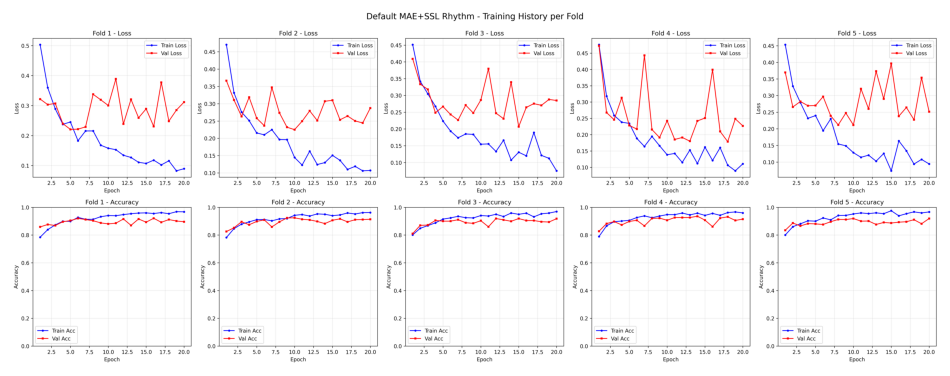

Generating training history HPO MAE Rhythm plots per fold...


HPO MAE Rhythm - Training History per Fold:


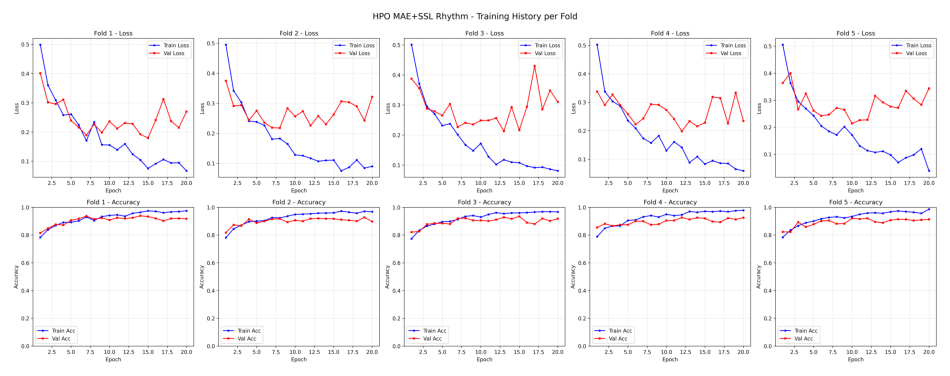

In [16]:
print("\nGenerating training history Default MAE Rhythm plots per fold...")
plot_training_history_per_fold(folds_default, 'Default MAE+SSL Rhythm', 'default_mae_ssl_rhythm')

print("\n\nDefault MAE Rhythm - Training History per Fold:")
img = mpimg.imread(f'{OUTPUT_DIRS["default_history"]}/default_mae_ssl_rhythm_training_history_per_fold.png')
plt.figure(figsize=(12, 12)) 
plt.imshow(img)
plt.axis('off')
plt.show()

if OPTUNA_AVAILABLE and 'folds_hpo' in locals():
    print("Generating training history HPO MAE Rhythm plots per fold...")
    plot_training_history_per_fold(folds_hpo, 'HPO MAE+SSL Rhythm', 'hpo_mae_ssl_rhythm')

    print("\n\nHPO MAE Rhythm - Training History per Fold:")
    img = mpimg.imread(f'{OUTPUT_DIRS["hpo_history"]}/hpo_mae_ssl_rhythm_training_history_per_fold.png')
    plt.figure(figsize=(12, 12)) 
    plt.imshow(img)
    plt.axis('off')
    plt.show()


## 9.4. Classification Report per Fold - Default MAE+SSL & HPO MAE+SSL

In [17]:
print("\nGenerating classification Default MAE Rhythm reports per fold...")
reports_default = generate_classification_reports_per_fold(
    folds_default, default_cfg, DEFAULT_CONFIG['dataset']['classes'], 'Default MAE Rhythm', 'default_mae_ssl_rhythm'
)

if OPTUNA_AVAILABLE and 'folds_hpo' in locals():
    print("\nGenerating classification HPO MAE Rhythm reports per fold...")
    reports_hpo = generate_classification_reports_per_fold(
        folds_hpo, hpo_cfg, DEFAULT_CONFIG['dataset']['classes'], 'HPO MAE Rhythm', 'hpo_mae_ssl_rhythm'
    )



Generating classification Default MAE Rhythm reports per fold...

Default MAE Rhythm - CLASSIFICATION REPORTS PER FOLD

### FOLD 1 ###


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



--- FOLD 1 TRAIN CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        AFIB       0.96      0.99      0.98      1280
           N       0.99      0.96      0.98      1280
         VFL       0.99      1.00      1.00      1280

    accuracy                           0.98      3840
   macro avg       0.98      0.98      0.98      3840
weighted avg       0.98      0.98      0.98      3840


--- FOLD 1 VALIDATION CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        AFIB       0.87      0.84      0.85       320
           N       0.88      0.86      0.87       320
         VFL       0.93      0.99      0.96       320

    accuracy                           0.90       960
   macro avg       0.89      0.90      0.89       960
weighted avg       0.89      0.90      0.89       960


### FOLD 2 ###


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



--- FOLD 2 TRAIN CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        AFIB       0.98      0.98      0.98      1280
           N       0.97      0.98      0.97      1280
         VFL       1.00      0.99      0.99      1280

    accuracy                           0.98      3840
   macro avg       0.98      0.98      0.98      3840
weighted avg       0.98      0.98      0.98      3840


--- FOLD 2 VALIDATION CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        AFIB       0.89      0.88      0.89       320
           N       0.87      0.90      0.88       320
         VFL       0.99      0.96      0.97       320

    accuracy                           0.91       960
   macro avg       0.91      0.91      0.91       960
weighted avg       0.91      0.91      0.91       960


### FOLD 3 ###


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



--- FOLD 3 TRAIN CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        AFIB       0.99      0.98      0.98      1280
           N       0.98      0.98      0.98      1280
         VFL       1.00      1.00      1.00      1280

    accuracy                           0.99      3840
   macro avg       0.99      0.99      0.99      3840
weighted avg       0.99      0.99      0.99      3840


--- FOLD 3 VALIDATION CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        AFIB       0.90      0.86      0.88       320
           N       0.87      0.90      0.88       320
         VFL       0.98      0.99      0.98       320

    accuracy                           0.92       960
   macro avg       0.92      0.92      0.92       960
weighted avg       0.92      0.92      0.92       960


### FOLD 4 ###


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



--- FOLD 4 TRAIN CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        AFIB       0.99      0.89      0.94      1280
           N       0.90      0.99      0.94      1280
         VFL       1.00      1.00      1.00      1280

    accuracy                           0.96      3840
   macro avg       0.96      0.96      0.96      3840
weighted avg       0.96      0.96      0.96      3840


--- FOLD 4 VALIDATION CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        AFIB       0.94      0.82      0.88       320
           N       0.83      0.96      0.89       320
         VFL       0.98      0.97      0.97       320

    accuracy                           0.91       960
   macro avg       0.92      0.91      0.91       960
weighted avg       0.92      0.91      0.91       960


### FOLD 5 ###


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



--- FOLD 5 TRAIN CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        AFIB       0.98      0.98      0.98      1280
           N       0.98      0.99      0.98      1280
         VFL       1.00      0.99      0.99      1280

    accuracy                           0.99      3840
   macro avg       0.99      0.99      0.99      3840
weighted avg       0.99      0.99      0.99      3840


--- FOLD 5 VALIDATION CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        AFIB       0.91      0.87      0.88       320
           N       0.88      0.92      0.90       320
         VFL       0.98      0.97      0.97       320

    accuracy                           0.92       960
   macro avg       0.92      0.92      0.92       960
weighted avg       0.92      0.92      0.92       960


Generating classification HPO MAE Rhythm reports per fold...

HPO MAE Rhythm - CLASSIFICATION REPORTS PER FOLD

### FOLD 1 ###


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



--- FOLD 1 TRAIN CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        AFIB       0.99      0.93      0.96      1280
           N       0.94      0.99      0.97      1280
         VFL       0.99      1.00      1.00      1280

    accuracy                           0.97      3840
   macro avg       0.97      0.97      0.97      3840
weighted avg       0.97      0.97      0.97      3840


--- FOLD 1 VALIDATION CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        AFIB       0.95      0.82      0.88       320
           N       0.86      0.94      0.90       320
         VFL       0.95      0.99      0.97       320

    accuracy                           0.92       960
   macro avg       0.92      0.92      0.92       960
weighted avg       0.92      0.92      0.92       960


### FOLD 2 ###


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



--- FOLD 2 TRAIN CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        AFIB       0.96      0.96      0.96      1280
           N       0.96      0.97      0.96      1280
         VFL       1.00      0.99      1.00      1280

    accuracy                           0.97      3840
   macro avg       0.97      0.97      0.97      3840
weighted avg       0.97      0.97      0.97      3840


--- FOLD 2 VALIDATION CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        AFIB       0.85      0.84      0.85       320
           N       0.85      0.88      0.86       320
         VFL       0.98      0.97      0.98       320

    accuracy                           0.90       960
   macro avg       0.90      0.90      0.90       960
weighted avg       0.90      0.90      0.90       960


### FOLD 3 ###


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



--- FOLD 3 TRAIN CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        AFIB       0.96      0.99      0.98      1280
           N       0.99      0.96      0.97      1280
         VFL       1.00      1.00      1.00      1280

    accuracy                           0.98      3840
   macro avg       0.98      0.98      0.98      3840
weighted avg       0.98      0.98      0.98      3840


--- FOLD 3 VALIDATION CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        AFIB       0.85      0.92      0.89       320
           N       0.91      0.86      0.88       320
         VFL       0.99      0.98      0.98       320

    accuracy                           0.92       960
   macro avg       0.92      0.92      0.92       960
weighted avg       0.92      0.92      0.92       960


### FOLD 4 ###


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



--- FOLD 4 TRAIN CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        AFIB       0.99      0.98      0.99      1280
           N       0.98      0.98      0.98      1280
         VFL       0.99      1.00      0.99      1280

    accuracy                           0.99      3840
   macro avg       0.99      0.99      0.99      3840
weighted avg       0.99      0.99      0.99      3840


--- FOLD 4 VALIDATION CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        AFIB       0.90      0.88      0.89       320
           N       0.91      0.90      0.91       320
         VFL       0.96      0.99      0.98       320

    accuracy                           0.93       960
   macro avg       0.92      0.93      0.92       960
weighted avg       0.92      0.93      0.92       960


### FOLD 5 ###


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



--- FOLD 5 TRAIN CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        AFIB       1.00      0.97      0.98      1280
           N       0.97      1.00      0.98      1280
         VFL       1.00      1.00      1.00      1280

    accuracy                           0.99      3840
   macro avg       0.99      0.99      0.99      3840
weighted avg       0.99      0.99      0.99      3840


--- FOLD 5 VALIDATION CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        AFIB       0.92      0.82      0.87       320
           N       0.86      0.93      0.89       320
         VFL       0.96      0.98      0.97       320

    accuracy                           0.91       960
   macro avg       0.91      0.91      0.91       960
weighted avg       0.91      0.91      0.91       960



## 9.5.  Confusion Matrix per Fold - Default MAE+SSL & HPO MAE+SSL


Generating Confusion Matrix Default MAE Rhythm per fold...

Default MAE Rhythm - CONFUSION MATRIX PER FOLD

### FOLD 1 CONFUSION MATRIX ###


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Fold 1 Train Confusion Matrix saved.


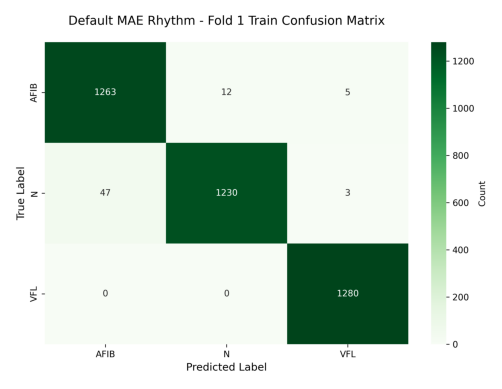

Fold 1 Validation Confusion Matrix saved.


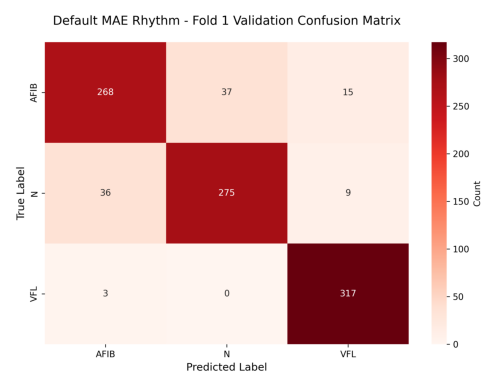


### FOLD 2 CONFUSION MATRIX ###


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Fold 2 Train Confusion Matrix saved.


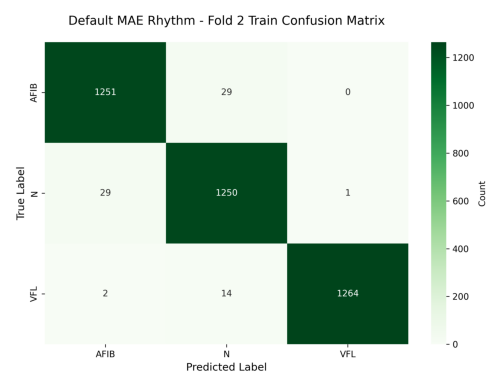

Fold 2 Validation Confusion Matrix saved.


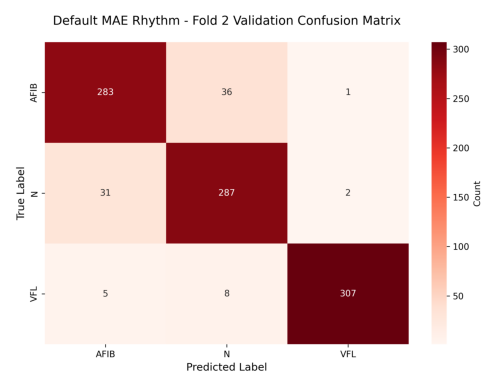


### FOLD 3 CONFUSION MATRIX ###


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Fold 3 Train Confusion Matrix saved.


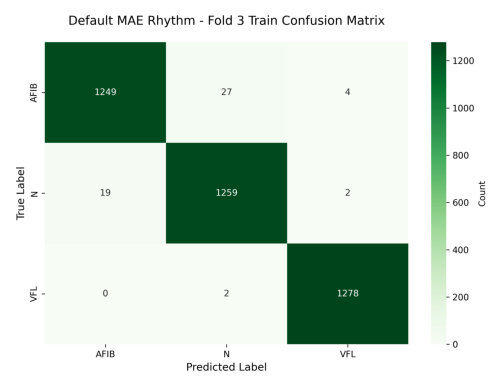

Fold 3 Validation Confusion Matrix saved.


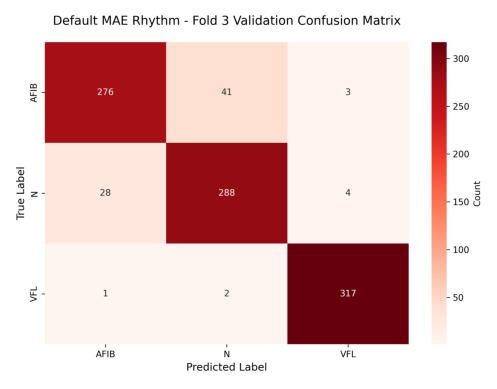


### FOLD 4 CONFUSION MATRIX ###


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Fold 4 Train Confusion Matrix saved.


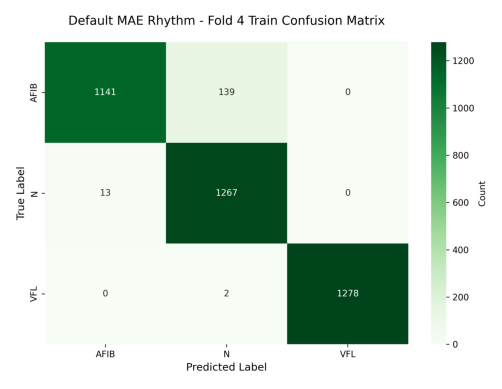

Fold 4 Validation Confusion Matrix saved.


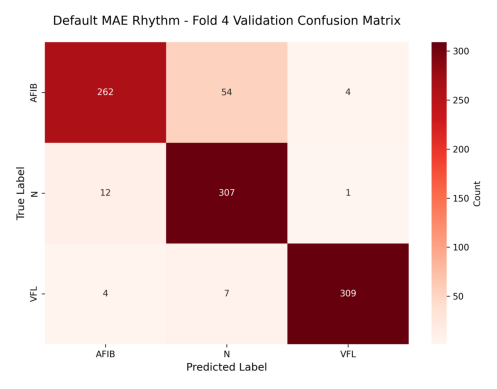


### FOLD 5 CONFUSION MATRIX ###


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Fold 5 Train Confusion Matrix saved.


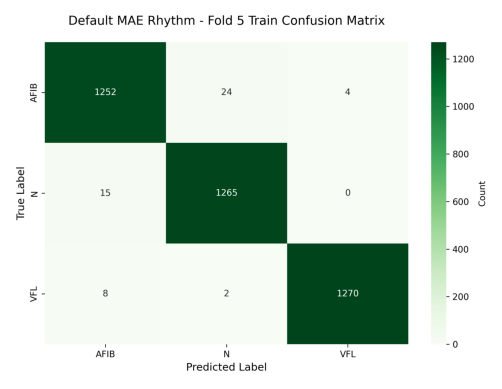

Fold 5 Validation Confusion Matrix saved.


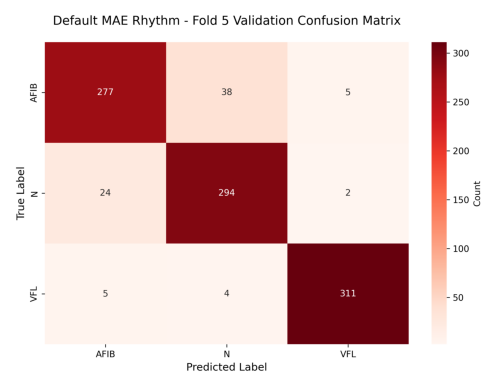


Generating Confusion Matrix HPO MAE Rhythm per fold...

HPO MAE Rhythm - CONFUSION MATRIX PER FOLD

### FOLD 1 CONFUSION MATRIX ###


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Fold 1 Train Confusion Matrix saved.


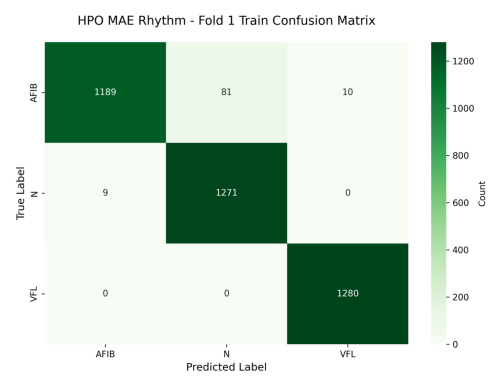

Fold 1 Validation Confusion Matrix saved.


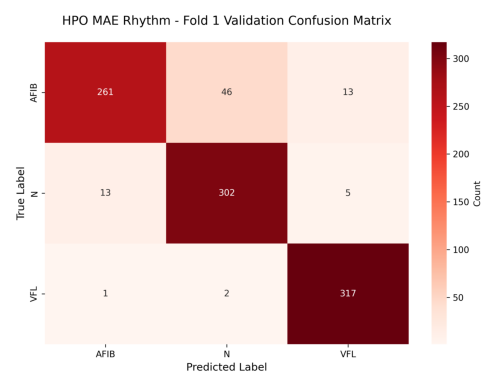


### FOLD 2 CONFUSION MATRIX ###


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Fold 2 Train Confusion Matrix saved.


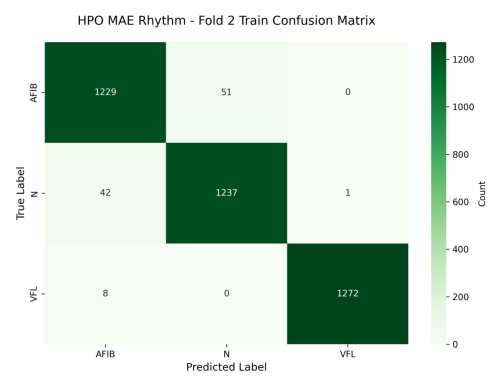

Fold 2 Validation Confusion Matrix saved.


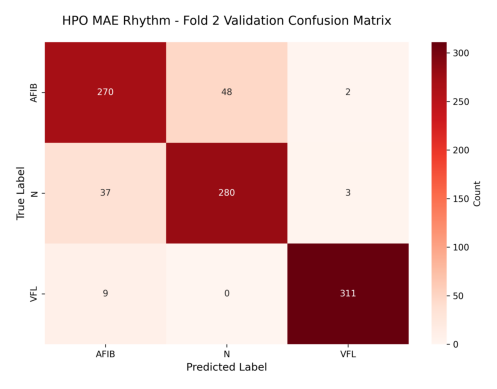


### FOLD 3 CONFUSION MATRIX ###


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Fold 3 Train Confusion Matrix saved.


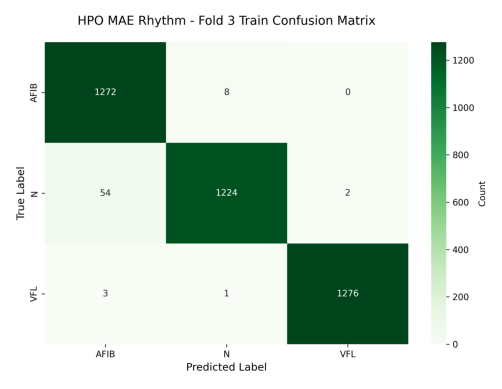

Fold 3 Validation Confusion Matrix saved.


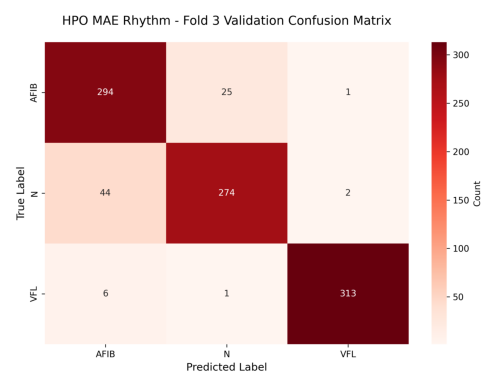


### FOLD 4 CONFUSION MATRIX ###


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Fold 4 Train Confusion Matrix saved.


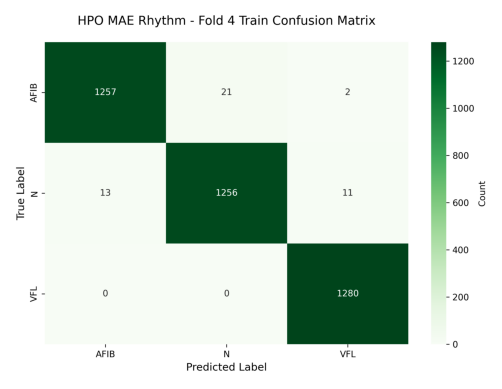

Fold 4 Validation Confusion Matrix saved.


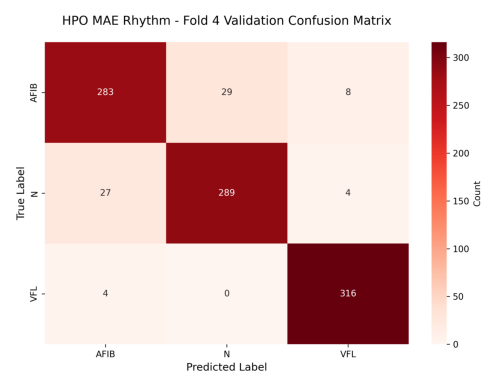


### FOLD 5 CONFUSION MATRIX ###


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Fold 5 Train Confusion Matrix saved.


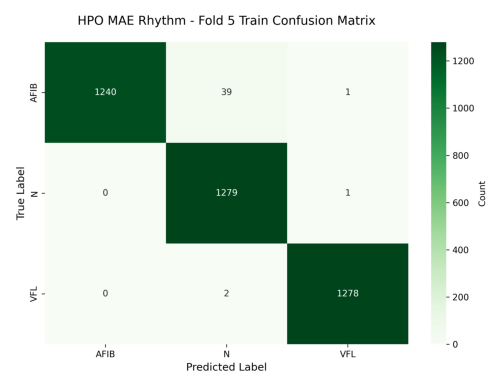

Fold 5 Validation Confusion Matrix saved.


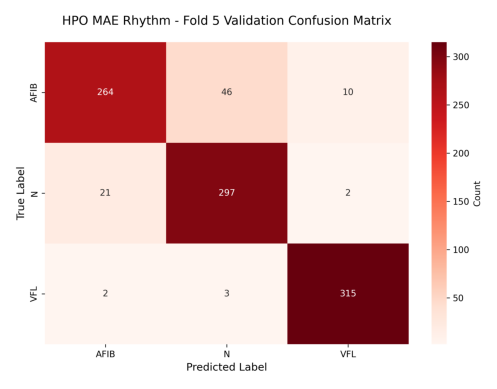

In [18]:
print("\nGenerating Confusion Matrix Default MAE Rhythm per fold...")
cm_default = generate_confusion_matrices_per_fold(
    folds_default, default_cfg, DEFAULT_CONFIG['dataset']['classes'], 'Default MAE Rhythm', 'default_mae_ssl_rhythm'
)

if OPTUNA_AVAILABLE and 'folds_hpo' in locals():
    print("\nGenerating Confusion Matrix HPO MAE Rhythm per fold...")
    cm_hpo = generate_confusion_matrices_per_fold(
        folds_hpo, hpo_cfg, DEFAULT_CONFIG['dataset']['classes'], 'HPO MAE Rhythm', 'hpo_mae_ssl_rhythm'
    )


## 9.6. Best Fold Default MAE+SSL & HPO MAE+SSL - Train & Test Evaluation

### 9.6.1. Default MAE


Getting train predictions for Default MAE Rhythm...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False beca


--- Classification Report Train Default MAE Rhythm ---
              precision    recall  f1-score   support

        AFIB       0.98      0.96      0.97      6400
           N       0.96      0.98      0.97      6400
         VFL       1.00      1.00      1.00      6400

    accuracy                           0.98     19200
   macro avg       0.98      0.98      0.98     19200
weighted avg       0.98      0.98      0.98     19200

Generating Confusion Matrix Train Default MAE Rhythm...
Confusion Matrix Train Default MAE Rhythm:



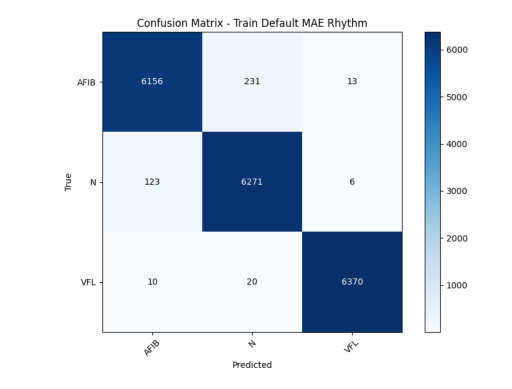


Evaluating Default MAE Rhythm on test set...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Test Accuracy Default MAE Rhythm: 0.9208
Test Loss Default MAE Rhythm: 0.2018

--- Classification Report Test Default MAE Rhythm ---
              precision    recall  f1-score   support

        AFIB       0.89      0.88      0.89       400
           N       0.88      0.92      0.90       400
         VFL       0.99      0.96      0.98       400

    accuracy                           0.92      1200
   macro avg       0.92      0.92      0.92      1200
weighted avg       0.92      0.92      0.92      1200

Generating Confusion Matrix Test Default MAE Rhythm...
Confusion Matrix Test Default MAE Rhythm:



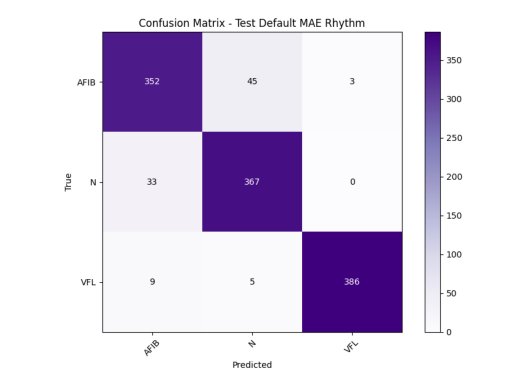

In [19]:
print("\nGetting train predictions for Default MAE Rhythm...")
train_preds_default, train_trues_default = get_train_predictions(folds_default, default_cfg)

print("\n--- Classification Report Train Default MAE Rhythm ---")
print(classification_report(train_trues_default, train_preds_default, target_names=DEFAULT_CONFIG['dataset']['classes']))

print("Generating Confusion Matrix Train Default MAE Rhythm...")
cm_train_default = confusion_matrix(train_trues_default, train_preds_default)
print('Confusion Matrix Train Default MAE Rhythm:\n')

plt.figure(figsize=(8,6))
plt.imshow(cm_train_default, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix - Train Default MAE Rhythm')
plt.colorbar()

for i in range(len(DEFAULT_CONFIG['dataset']['classes'])):
    for j in range(len(DEFAULT_CONFIG['dataset']['classes'])):
        plt.text(j, i, str(cm_train_default[i, j]),
                 ha="center", va="center",
                 color="white" if cm_train_default[i, j] > cm_train_default.max()/2 else "black")

tick_marks = np.arange(len(DEFAULT_CONFIG['dataset']['classes']))
plt.xticks(tick_marks, DEFAULT_CONFIG['dataset']['classes'], rotation=45)
plt.yticks(tick_marks, DEFAULT_CONFIG['dataset']['classes'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIRS["default_matrix"]}/train_default_mae_ssl_rhythm_confusion_matrix.png')
plt.close()

img = mpimg.imread(f'{OUTPUT_DIRS["default_matrix"]}/train_default_mae_ssl_rhythm_confusion_matrix.png')
plt.imshow(img)
plt.axis('off')
plt.show()

print("\nEvaluating Default MAE Rhythm on test set...")
best_model_path = f'{OUTPUT_DIRS["default_models"]}/default_mae_ssl_fold{best_fold_default}.pth'
test_loss_default, test_acc_default, test_preds_default, test_trues_default = evaluate_model_on_test_set(
    best_model_path, default_cfg, DEFAULT_CONFIG['dataset']['test_dirs'], DEFAULT_CONFIG['dataset']['classes']
)

print(f"Test Accuracy Default MAE Rhythm: {test_acc_default:.4f}")
print(f"Test Loss Default MAE Rhythm: {test_loss_default:.4f}")

print("\n--- Classification Report Test Default MAE Rhythm ---")
print(classification_report(test_trues_default, test_preds_default, target_names=DEFAULT_CONFIG['dataset']['classes']))

print("Generating Confusion Matrix Test Default MAE Rhythm...")
cm_test_default = confusion_matrix(test_trues_default, test_preds_default)
print('Confusion Matrix Test Default MAE Rhythm:\n')

plt.figure(figsize=(8,6))
plt.imshow(cm_test_default, interpolation='nearest', cmap='Purples')
plt.title('Confusion Matrix - Test Default MAE Rhythm')
plt.colorbar()

for i in range(len(DEFAULT_CONFIG['dataset']['classes'])):
    for j in range(len(DEFAULT_CONFIG['dataset']['classes'])):
        plt.text(j, i, str(cm_test_default[i, j]),
                 ha="center", va="center",
                 color="white" if cm_test_default[i, j] > cm_test_default.max()/2 else "black")

tick_marks = np.arange(len(DEFAULT_CONFIG['dataset']['classes']))
plt.xticks(tick_marks, DEFAULT_CONFIG['dataset']['classes'], rotation=45)
plt.yticks(tick_marks, DEFAULT_CONFIG['dataset']['classes'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIRS["default_matrix"]}/test_default_mae_ssl_rhythm_confusion_matrix.png')
plt.close()

img = mpimg.imread(f'{OUTPUT_DIRS["default_matrix"]}/test_default_mae_ssl_rhythm_confusion_matrix.png')
plt.imshow(img)
plt.axis('off')
plt.show()

### 9.6.2. HPO MAE


Getting train predictions for HPO MAE Rhythm...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False beca


--- Classification Report Train Hyperparameter Tuning MAE Rhythm ---
              precision    recall  f1-score   support

        AFIB       0.98      0.97      0.97      6400
           N       0.97      0.98      0.97      6400
         VFL       1.00      1.00      1.00      6400

    accuracy                           0.98     19200
   macro avg       0.98      0.98      0.98     19200
weighted avg       0.98      0.98      0.98     19200

Generating Confusion Matrix Train HPO MAE Rhythm...
Confusion Matrix Train HPO MAE Rhythm:



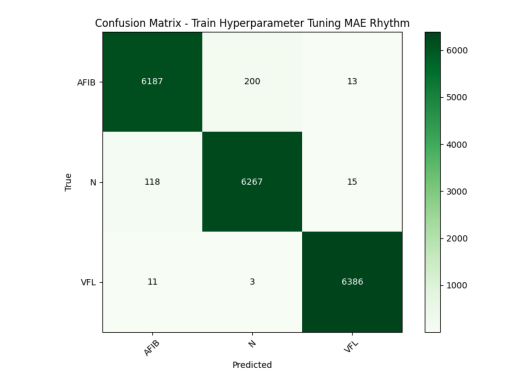


Evaluating HPO MAE Rhythm on test set...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Test Accuracy HPO MAE Rhythm: 0.9192
Test Loss HPO MAE Rhythm: 0.2402

--- Classification Report Test Hyperparameter Tuning MAE Rhythm ---
              precision    recall  f1-score   support

        AFIB       0.93      0.84      0.88       400
           N       0.87      0.93      0.90       400
         VFL       0.96      0.99      0.98       400

    accuracy                           0.92      1200
   macro avg       0.92      0.92      0.92      1200
weighted avg       0.92      0.92      0.92      1200

Generating Confusion Matrix Test HPO MAE Rhythm...
Confusion Matrix Test HPO MAE Rhythm:
 [[335  53  12]
 [ 24 372   4]
 [  3   1 396]]


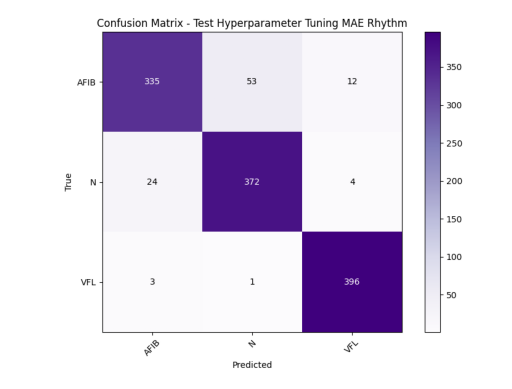

In [20]:

if OPTUNA_AVAILABLE and 'folds_hpo' in locals():
    print("\nGetting train predictions for HPO MAE Rhythm...")
    train_preds_hpo, train_trues_hpo = get_train_predictions(folds_hpo, hpo_cfg)
    
    print("\n--- Classification Report Train Hyperparameter Tuning MAE Rhythm ---")
    print(classification_report(train_trues_hpo, train_preds_hpo, target_names=DEFAULT_CONFIG['dataset']['classes']))
    
    print("Generating Confusion Matrix Train HPO MAE Rhythm...")
    cm_train_hpo = confusion_matrix(train_trues_hpo, train_preds_hpo)
    print('Confusion Matrix Train HPO MAE Rhythm:\n')
    
    plt.figure(figsize=(8,6))
    plt.imshow(cm_train_hpo, interpolation='nearest', cmap='Greens')
    plt.title('Confusion Matrix - Train Hyperparameter Tuning MAE Rhythm')
    plt.colorbar()
    
    for i in range(len(DEFAULT_CONFIG['dataset']['classes'])):
        for j in range(len(DEFAULT_CONFIG['dataset']['classes'])):
            plt.text(j, i, str(cm_train_hpo[i, j]),
                     ha="center", va="center",
                     color="white" if cm_train_hpo[i, j] > cm_train_hpo.max()/2 else "black")
    
    tick_marks = np.arange(len(DEFAULT_CONFIG['dataset']['classes']))
    plt.xticks(tick_marks, DEFAULT_CONFIG['dataset']['classes'], rotation=45)
    plt.yticks(tick_marks, DEFAULT_CONFIG['dataset']['classes'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIRS["hpo_matrix"]}/train_hpo_mae_ssl_rhythm_confusion_matrix.png')
    plt.close()

    img = mpimg.imread(f'{OUTPUT_DIRS["hpo_matrix"]}/train_hpo_mae_ssl_rhythm_confusion_matrix.png')
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    print("\nEvaluating HPO MAE Rhythm on test set...")
    best_model_path_hpo = f'{OUTPUT_DIRS["hpo_models"]}/hpo_mae_ssl_fold{best_fold_hpo}.pth'
    test_loss_hpo, test_acc_hpo, test_preds_hpo, test_trues_hpo = evaluate_model_on_test_set(
        best_model_path_hpo, hpo_cfg, DEFAULT_CONFIG['dataset']['test_dirs'], DEFAULT_CONFIG['dataset']['classes']
    )
    
    print(f"Test Accuracy HPO MAE Rhythm: {test_acc_hpo:.4f}")
    print(f"Test Loss HPO MAE Rhythm: {test_loss_hpo:.4f}")
    
    print("\n--- Classification Report Test Hyperparameter Tuning MAE Rhythm ---")
    print(classification_report(test_trues_hpo, test_preds_hpo, target_names=DEFAULT_CONFIG['dataset']['classes']))
    
    print("Generating Confusion Matrix Test HPO MAE Rhythm...")
    cm_test_hpo = confusion_matrix(test_trues_hpo, test_preds_hpo)
    print('Confusion Matrix Test HPO MAE Rhythm:\n', cm_test_hpo)
    
    plt.figure(figsize=(8,6))
    plt.imshow(cm_test_hpo, interpolation='nearest', cmap='Purples')
    plt.title('Confusion Matrix - Test Hyperparameter Tuning MAE Rhythm')
    plt.colorbar()
    
    for i in range(len(DEFAULT_CONFIG['dataset']['classes'])):
        for j in range(len(DEFAULT_CONFIG['dataset']['classes'])):
            plt.text(j, i, str(cm_test_hpo[i, j]),
                     ha="center", va="center",
                     color="white" if cm_test_hpo[i, j] > cm_test_hpo.max()/2 else "black")
    
    tick_marks = np.arange(len(DEFAULT_CONFIG['dataset']['classes']))
    plt.xticks(tick_marks, DEFAULT_CONFIG['dataset']['classes'], rotation=45)
    plt.yticks(tick_marks, DEFAULT_CONFIG['dataset']['classes'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIRS["hpo_matrix"]}/test_hpo_mae_ssl_rhythm_confusion_matrix.png')
    plt.close()

    img = mpimg.imread(f'{OUTPUT_DIRS["hpo_matrix"]}/test_hpo_mae_ssl_rhythm_confusion_matrix.png')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

## 9.7. Default MAE+SSL & HPO MAE+SSL - Parameter Comparison

In [21]:
if OPTUNA_AVAILABLE and 'folds_hpo' in locals():
    compare_configurations(default_cfg, hpo_cfg, output_dir=OUTPUT_DIRS['outputs'])
else:
    compare_configurations(default_cfg, None, output_dir=OUTPUT_DIRS['outputs'])



=== Parameter Comparison ===
Parameter                | Default Config | Best HPO Config
------------------------------------------------------------
Device                   | cuda           | cuda           
Epoch                    | 20             | 20             
Batch Size               | 64             | 64             
Learning Rate            | 0.001          | 0.0006949810157401428
Weight Decay             | 0.0001         | 1.0665286175832182e-06
Model Dimension          | 128            | 128            
Number of Heads          | 4              | 8              
Mask Ratio               | 0.5            | 0.39762648893189373
Dropout                  | 0.1            | 0.1            

✅ Parameter comparison saved to: MAE_SSL_RHYTHM/parameter_comparison_rhythm.xlsx


## 9.8. Export Detailed Metrics Table to Excel

In [22]:
print("Generating updated detailed metrics table for Default MAE Rhythm...")
df_default_updated = create_detailed_metrics_table_updated(folds_default, default_cfg, "Default MAE Rhythm", DEFAULT_CONFIG['dataset']['classes'])
display_metrics_table(df_default_updated, "Default Train MAE Rhythm Metrics (Updated Accuracy)")

df_hpo_updated = None
fold_results_hpo_for_excel = None
hpo_cfg_for_excel = None

if OPTUNA_AVAILABLE and 'folds_hpo' in locals():
    print("\nGenerating updated detailed metrics table for HPO MAE Rhythm...")
    df_hpo_updated = create_detailed_metrics_table_updated(folds_hpo, hpo_cfg, "HPO MAE Rhythm", DEFAULT_CONFIG['dataset']['classes'])
    display_metrics_table(df_hpo_updated, "Tuning Train MAE Rhythm Metrics (Updated Accuracy)")
    fold_results_hpo_for_excel = folds_hpo
    hpo_cfg_for_excel = hpo_cfg

print("\nSaving enhanced Excel file with test results for best folds...")
save_metrics_to_excel_enhanced_updated(
    df_default_updated, 
    df_hpo_updated, 
    fold_results_default=folds_default,
    fold_results_hpo=fold_results_hpo_for_excel,
    default_cfg=default_cfg,
    hpo_cfg=hpo_cfg_for_excel,
    classes=DEFAULT_CONFIG['dataset']['classes']
)

if df_hpo_updated is not None:
    print(f"\n{'='*160}")
    print(f"{'SIDE-BY-SIDE COMPARISON (Updated Accuracy Calculation)':^160}")
    print('='*160)
    print(f"{'Default Train MAE Rhythm':<80} {'Tuning Train MAE Rhythm':<80}")
    print('-'*160)
    print(f"{'Fold':<8} {'Class':<5} {'Acc':<8} {'Sens':<8} {'Spec':<8} {'F1':<8} | {'Fold':<8} {'Class':<5} {'Acc':<8} {'Sens':<8} {'Spec':<8} {'F1':<8}")
    print('-'*160)
    
    max_rows = max(len(df_default_updated), len(df_hpo_updated))
    for i in range(max_rows):
        left_row = df_default_updated.iloc[i] if i < len(df_default_updated) else {'Fold': '', 'Class': '', 'Accuracy': '', 'Sensitivity': '', 'Specificity': '', 'F1-Score': ''}
        right_row = df_hpo_updated.iloc[i] if i < len(df_hpo_updated) else {'Fold': '', 'Class': '', 'Accuracy': '', 'Sensitivity': '', 'Specificity': '', 'F1-Score': ''}
        
        left_fold = left_row['Fold'].replace('Fold ', '') if 'Fold' in str(left_row['Fold']) else left_row['Fold']
        right_fold = right_row['Fold'].replace('Fold ', '') if 'Fold' in str(right_row['Fold']) else right_row['Fold']
        
        print(f"{left_fold:<8} {left_row['Class']:<5} {left_row['Accuracy']:<8} {left_row['Sensitivity']:<8} {left_row['Specificity']:<8} {left_row['F1-Score']:<8} | {right_fold:<8} {right_row['Class']:<5} {right_row['Accuracy']:<8} {right_row['Sensitivity']:<8} {right_row['Specificity']:<8} {right_row['F1-Score']:<8}")

print(f"\n{'='*80}")
print("UPDATED DETAILED METRICS TABLE GENERATION COMPLETED FOR RHYTHM CLASSIFICATION")
print("Excel file now includes the following sheets:")
print("1. Default_Train_MAE_SSL_RHYTHM - All folds training metrics for Default MAE")
print("2. Tuning_Train_MAE_SSL_RHYTHM - All folds training metrics for HPO MAE") 
print("3. Default_Test_MAE_SSL_RHYTHM - Test metrics for best Default MAE fold")
print("4. Tuning_Test_MAE_SSL_RHYTHM - Test metrics for best HPO MAE fold")
print("") 
print('='*80)

print("\n\n🎉 ALL EVALUATIONS COMPLETED SUCCESSFULLY! 🎉")
print(f"All results saved in: {OUTPUT_DIRS['outputs']}")
print("\nOutput Structure:")
print("├── MAE_SSL_RHYTHM/")
print("│   ├── README.md")
print("│   ├── class_mapping.json")
print("│   ├── config_default.json")
print("│   ├── config_hpo.json (if HPO was run)")
print("│   ├── detailed_metrics_comparison_rhythm.xlsx")
print("│   ├── parameter_comparison_rhythm.xlsx")
print("│   │")
print("│   ├── Default_MAE_SSL/")
print("│   │   ├── Model_Save/")
print("│   │   ├── Training_History/")
print("│   │   └── Matrix/")
print("│   │")
print("│   └── HPO_MAE_SSL/ (if HPO was run)")
print("│       ├── Model_Save/")
print("│       ├── Training_History/")
print("│       └── Matrix/")
print("\n" + "="*80)

Generating updated detailed metrics table for Default MAE Rhythm...
Processing Default MAE Rhythm - Fold 1...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Processing Default MAE Rhythm - Fold 2...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Processing Default MAE Rhythm - Fold 3...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Processing Default MAE Rhythm - Fold 4...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Processing Default MAE Rhythm - Fold 5...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False beca


              Default Train MAE Rhythm Metrics (Updated Accuracy)               

Fold 1          AFIB  0.9833     0.9867       0.9816       0.9753    
                N     0.9839     0.9609       0.9953       0.9754    
                VFL   0.9979     1.0000       0.9969       0.9969    
                All   0.9884     0.9826       0.9913       0.9825    
--------------------------------------------------------------------------------

Fold 2          AFIB  0.9844     0.9773       0.9879       0.9766    
                N     0.9810     0.9766       0.9832       0.9716    
                VFL   0.9956     0.9875       0.9996       0.9933    
                All   0.9870     0.9805       0.9902       0.9805    
--------------------------------------------------------------------------------

Fold 3          AFIB  0.9870     0.9758       0.9926       0.9804    
                N     0.9870     0.9836       0.9887       0.9805    
                VFL   0.9979     0.9984       0.9977 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Processing HPO MAE Rhythm - Fold 2...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Processing HPO MAE Rhythm - Fold 3...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Processing HPO MAE Rhythm - Fold 4...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Processing HPO MAE Rhythm - Fold 5...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False beca


               Tuning Train MAE Rhythm Metrics (Updated Accuracy)               

Fold 1          AFIB  0.9740     0.9289       0.9965       0.9596    
                N     0.9766     0.9930       0.9684       0.9658    
                VFL   0.9974     1.0000       0.9961       0.9961    
                All   0.9826     0.9740       0.9870       0.9739    
--------------------------------------------------------------------------------

Fold 2          AFIB  0.9737     0.9602       0.9805       0.9605    
                N     0.9755     0.9664       0.9801       0.9634    
                VFL   0.9977     0.9938       0.9996       0.9965    
                All   0.9823     0.9734       0.9867       0.9735    
--------------------------------------------------------------------------------

Fold 3          AFIB  0.9831     0.9938       0.9777       0.9751    
                N     0.9831     0.9563       0.9965       0.9741    
                VFL   0.9984     0.9969       0.9992 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Default_Test_MAE_SSL_RHYTHM sheet created successfully for best fold 5.
Generating Tuning_Test_MAE_SSL_RHYTHM sheet...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Tuning_Test_MAE_SSL_RHYTHM sheet created successfully for best fold 4.
Enhanced metrics with updated accuracy calculation saved to MAE_SSL_RHYTHM/detailed_metrics_comparison_rhythm.xlsx

                                                     SIDE-BY-SIDE COMPARISON (Updated Accuracy Calculation)                                                     
Default Train MAE Rhythm                                                         Tuning Train MAE Rhythm                                                         
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Fold     Class Acc      Sens     Spec     F1       | Fold     Class Acc      Sens     Spec     F1      
----------------------------------------------------------------------------------------------------------------------------------------------------------------
1        AFIB  0.9833   0.9867   0.9816   0.9753   | 1        AF

# 10. ZIP Output

In [23]:
folder_path = '/kaggle/working/MAE_SSL_RHYTHM'
output_zip = '/kaggle/working/MAE_SSL_RHYTHM.zip'

# Kompres seluruh folder menjadi ZIP
shutil.make_archive('/kaggle/working/MAE_SSL_RHYTHM', 'zip', folder_path)

# Tampilkan link untuk mengunduh ZIP
FileLink(output_zip)

/kaggle/working/MAE_SSL_RHYTHM.zip